In [91]:
import sys
sys.path.append('../../../')
from SynRBL.rsmi_utils import load_database
import re
from rdkit import Chem
from SynAnalysis.analysis_utils import remove_atom_mapping_from_reaction_smiles, count_boundary_atoms_products_and_calculate_changes, calculate_chemical_properties


In [93]:
import sys
import pandas as pd
sys.path.append('../../../')
from SynRBL.rsmi_utils import load_database
from SynAnalysis.analysis_utils import remove_atom_mapping_from_reaction_smiles,calculate_chemical_properties, count_boundary_atoms_products_and_calculate_changes
from IPython.display import clear_output

class AnalysisProcess:
    def __init__(self, list_data, pipeline_path, data_path):
        self.list_data = list_data
        self.pipeline_path = pipeline_path
        self.data_path = data_path
    
    def process_and_combine_datasets(self, remove_undetected=True):
        data_all = pd.DataFrame()
        
        for data_name in self.list_data:
            data_csv_path = f'{self.pipeline_path}/Validation/Analysis/SynRBL - {data_name}.csv'
            data = pd.read_csv(data_csv_path).drop(['Note'], axis=1)
            data.loc[data['Result'] == 'CONSIDER', 'Result'] = False
            data.loc[data['Result'] == 'FALSE', 'Result'] = False
            data.loc[data['Result'] == 'TRUE', 'Result'] = True
            
            merge_data_path = f'{self.data_path}/Validation_set/{data_name}/MCS/MCS_Impute.json.gz'
            mcs_data_path = f'{self.data_path}/Validation_set/{data_name}/mcs_based_reactions.json.gz'
            
            merge_data = load_database(merge_data_path)
            merge_data = count_boundary_atoms_products_and_calculate_changes(merge_data)
            mcs_data = load_database(mcs_data_path)
            id = [value['R-id'] for value in merge_data]
            mcs_data = [value for value in mcs_data if value['R-id'] in id]
            mcs_data = calculate_chemical_properties(mcs_data)
            clear_output(wait=False)
            
            combined_data = pd.concat([
                pd.DataFrame(mcs_data)[['R-id', 'reactions', 'carbon_difference', 'fragment_count', 'total_carbons', 'total_bonds', 'total_rings']],
                data,
                pd.DataFrame(merge_data)[['mcs_carbon_balanced', 'num_boundary', 'ring_change_merge', 'bond_change_merge']],
            ], axis=1)
            combined_data.loc[(combined_data['mcs_carbon_balanced'] == False) & (combined_data['Result'] == True), 'Result']=False
            if remove_undetected:
                combined_data = combined_data[combined_data['mcs_carbon_balanced'] == True]
            
            data_all = pd.concat([data_all, combined_data], axis=0)
        data_all = data_all.reset_index(drop=True)
        unnamed_columns = [col for col in data_all.columns if 'Unnamed' in col]
        data_all = data_all.drop(unnamed_columns, axis=1)

        return data_all

    def bin_value(self, value, bin_size=10):
        binned_value = (value // bin_size) * bin_size
        return binned_value

    def standardize_columns(self, data):
        data.loc[data['carbon_difference']>10, 'carbon_difference'] = '> 10'
        data.loc[data['fragment_count']>=7, 'fragment_count'] = '>6'
        data.loc[data['Bond Changes']>5, 'Bond Changes'] = '> 5'
        data.loc[data['bond_change_merge']>3, 'bond_change_merge'] = '> 3'
        data.loc[data['num_boundary']>=4, 'num_boundary'] = '>3'
        data['reactions'] = data['reactions'].apply(lambda x: remove_atom_mapping_from_reaction_smiles(x))
        data = data.drop_duplicates(subset=['reactions'])
        data['Result'] = data['Result'].astype('bool')
        return data

/tmp/ipykernel_371887/2182256272.py:56: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '> 10' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data['carbon_difference']>10, 'carbon_difference'] = '> 10'
/tmp/ipykernel_371887/2182256272.py:57: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '>6' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data['fragment_count']>=7, 'fragment_count'] = '>6'
/tmp/ipykernel_371887/2182256272.py:58: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '> 5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data['Bond Changes']>5, 'Bond Changes'] = '> 5'
/tmp/ipykernel_371887/2182256272.py:59: FutureWarning: Se

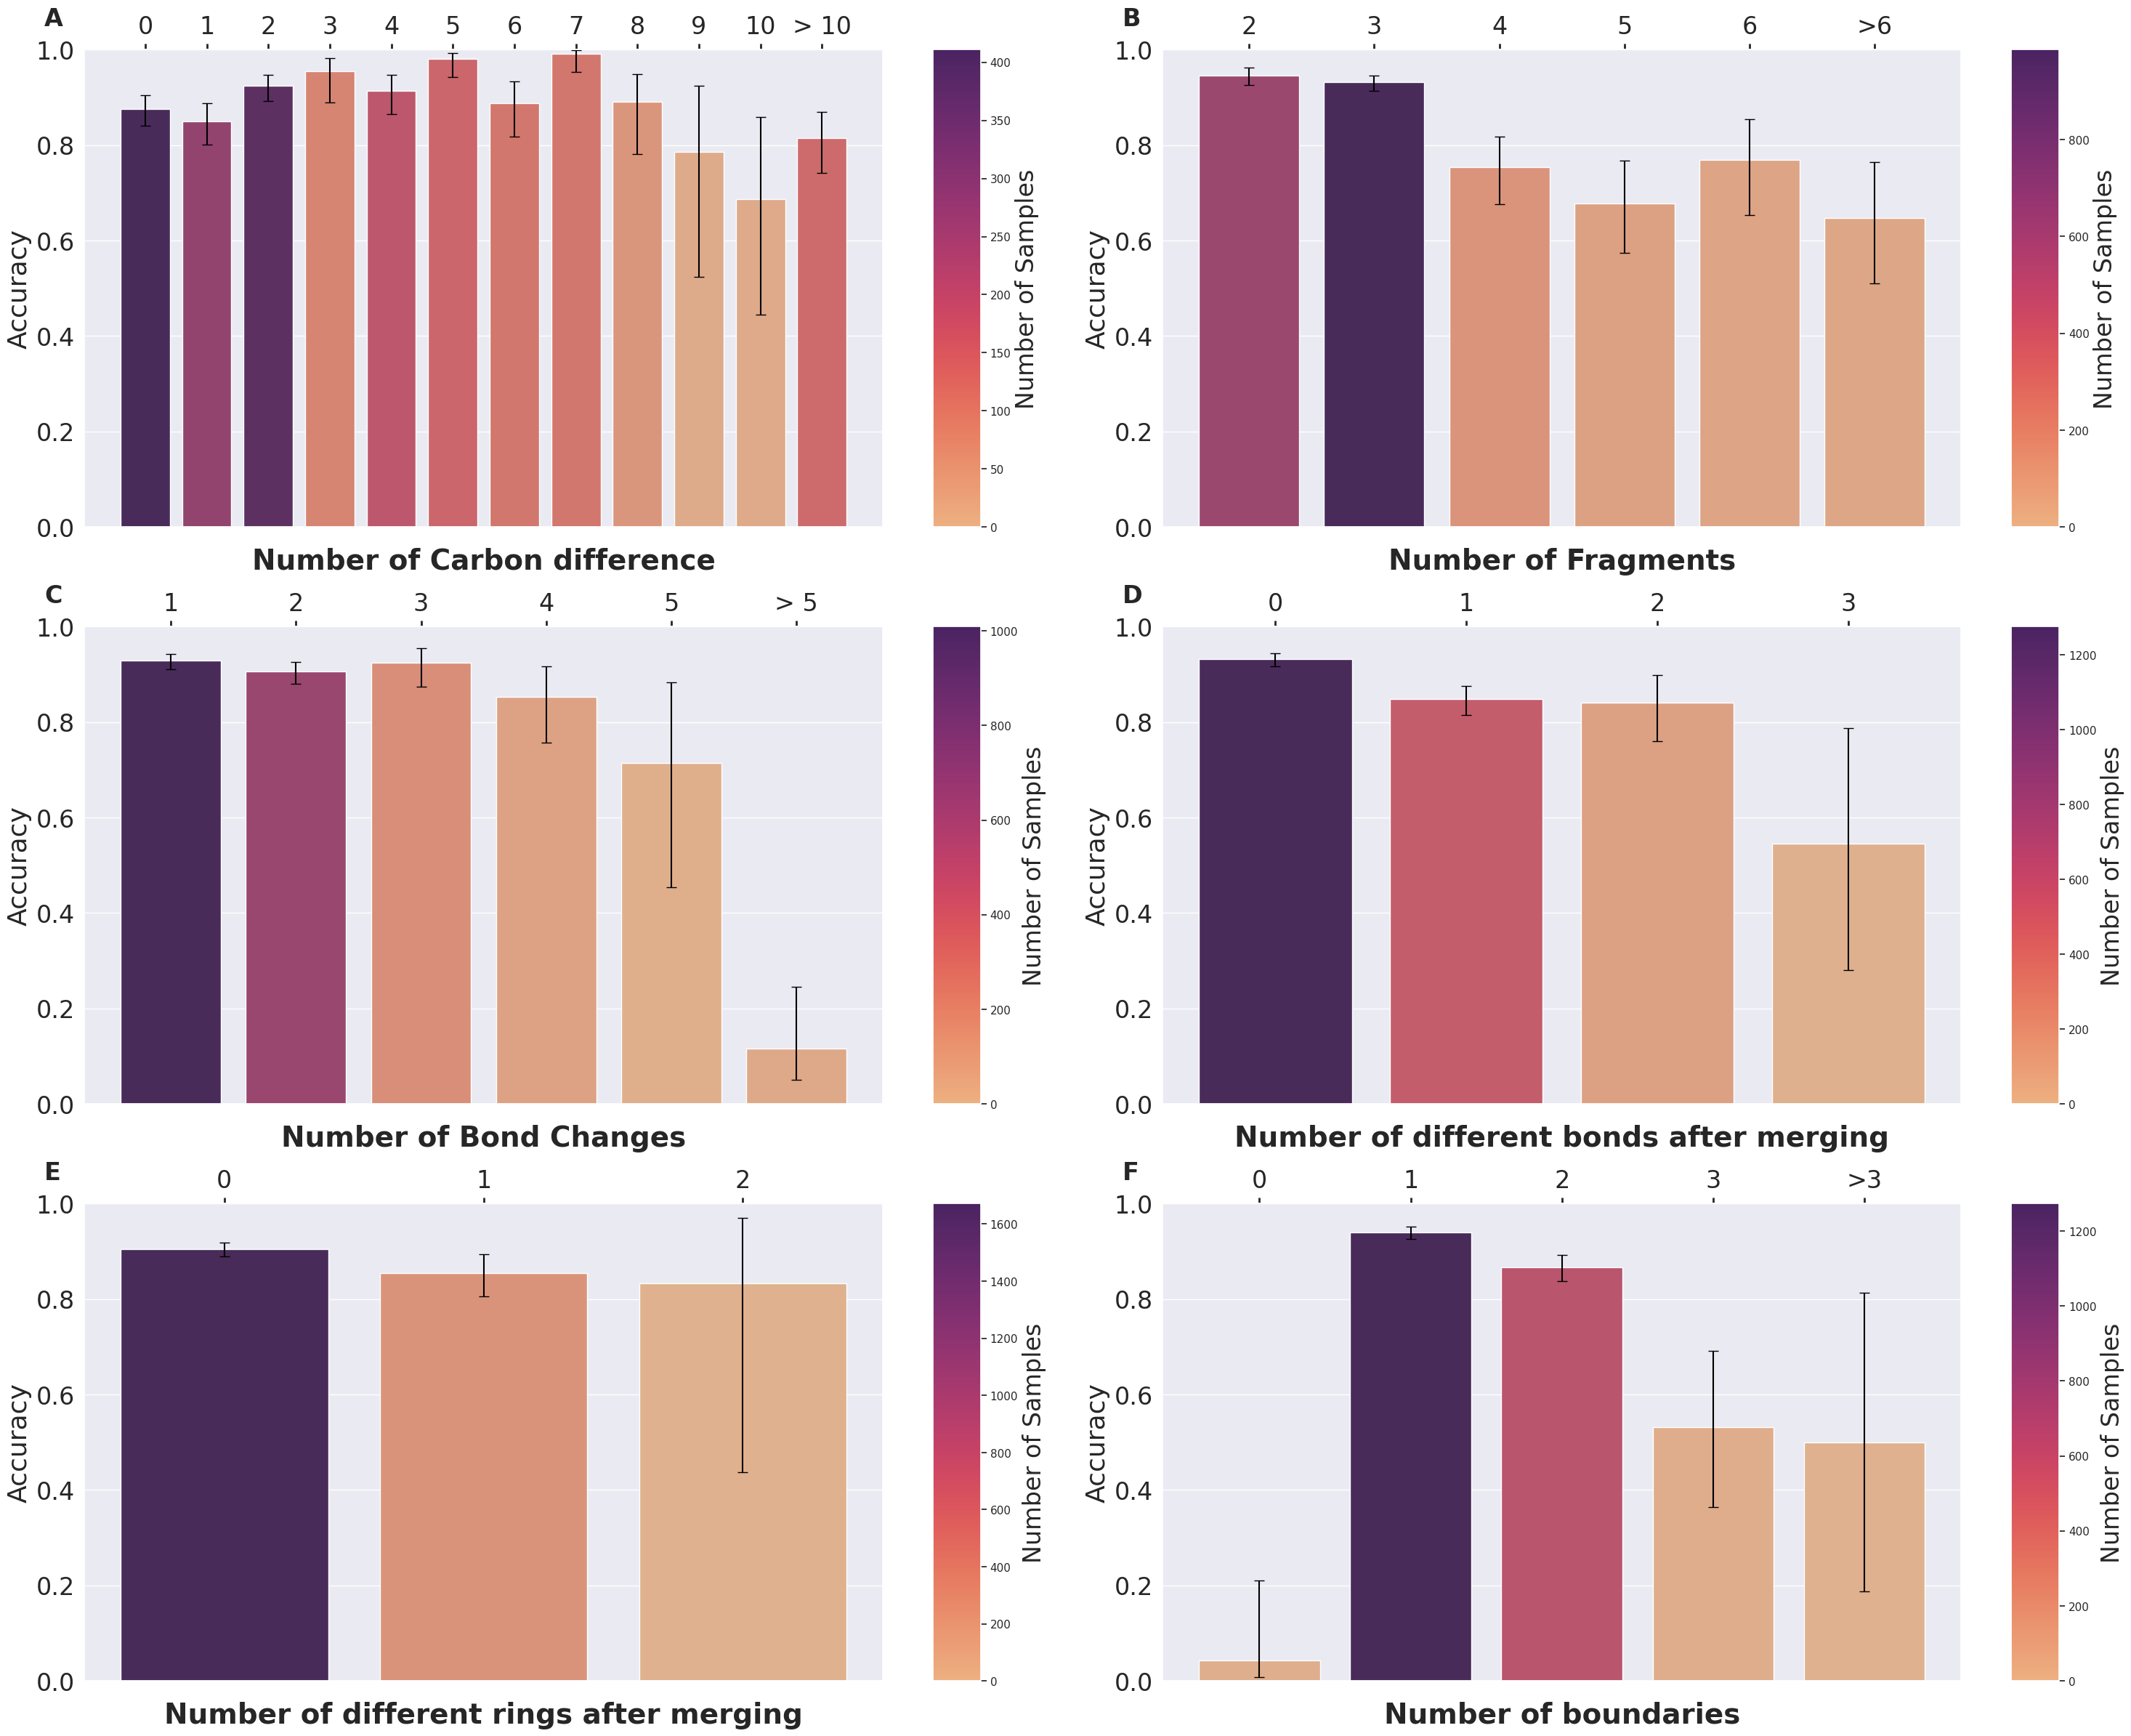

In [94]:
#from SynAnalysis.analysis_process import AnalysisProcess
list_data = ['golden_dataset', 'Jaworski', 'USPTO_random_class', 'USPTO_diff', 'USPTO_unbalance_class']
pipeline_path = '../../../Pipeline'
data_path = '../../../Data'
process = AnalysisProcess(list_data, pipeline_path, data_path)

data = process.process_and_combine_datasets(remove_undetected=True)
data_all = process.standardize_columns(data)
data_all = data_all.drop_duplicates(subset=['reactions'])
from SynAnalysis.eda_analysis import EDAVisualizer

columns = ['carbon_difference', 'fragment_count', 'Bond Changes', 'bond_change_merge', 'ring_change_merge', 'num_boundary']
titles = ['Number of Carbon difference', 'Number of Fragments', 'Number of Bond Changes', 'Number of different bonds after merging', 
          'Number of different rings after merging', 'Number of boundaries']
visualizer = EDAVisualizer(data_all, columns, titles)
visualizer.visualize_accuracy(chart_type='bar', show_values=False, error_bar=True, save_path='./EDA.png')

In [89]:
data_all

,R-id,reactions,carbon_difference,fragment_count,total_carbons,total_bonds,total_rings,Index,Result,Bond Changes,mcs_carbon_balanced,num_boundary,ring_change_merge,bond_change_merge
0,golden_dataset_1,C=CC(O)C(C)N.C=CCSCC(C)=O>>CC(=O)CSCC=CC(O)C(C)N,2,3,20,1,0,0,False,4,True,1,0,1
1,golden_dataset_2,C=CCC(CCC(COCc1ccccc1)O[Si](C)(C)C(C)(C)C)OS(C...,7,2,37,11,1,1,True,2,True,2,1,0
2,golden_dataset_7,CCOC(=O)C=Cc1ccc(NCCCCCCCCCCCCCC[Si](C)(C)C)cc...,2,2,54,2,0,2,True,1,True,1,0,0
3,golden_dataset_10,CCOC(=O)Cc1csc(-c2ccc(C(CC)(CC)c3ccc(C=CC(O)(C...,2,3,60,2,0,3,True,1,True,1,0,0
4,golden_dataset_11,C=CC(C)=O.C=CCCCC>>CCCCC=CC(C)=O,2,3,18,1,0,4,False,4,True,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2112,USPTO_unbalance_class_295,CC(C)(Cc1ccc(Cl)cc1Cl)C(=O)Cn1cncn1.C[S+](C)C>...,2,3,32,1,1,252,True,2,True,1,1,1
2113,USPTO_unbalance_class_296,C[S+](C)C.O=C(c1ccc(Cl)cc1)c1ccc(I)cc1>>Clc1cc...,2,3,30,1,1,253,True,2,True,1,1,1
2114,USPTO_unbalance_class_297,C[Si](C)(C)N=[N+]=[N-].N#Cc1ccc(C=O)cc1>>O=Cc1...,3,3,19,2,1,254,True,1,True,1,1,2
2115,USPTO_unbalance_class_298,COc1ccc(S(=O)(=O)N(CC#N)c2ccc(Cl)cc2C(=O)c2ccc...,3,3,49,2,1,255,True,1,True,1,1,2


/homes/biertank/tieu/Documents/Project/SynRBL/Pipeline/Validation/Analysis/SynAnalysis/analysis_process.py:56: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '> 10' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data['carbon_difference']>10, 'carbon_difference'] = '> 10'
/homes/biertank/tieu/Documents/Project/SynRBL/Pipeline/Validation/Analysis/SynAnalysis/analysis_process.py:57: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '> 8' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data['fragment_count']>8, 'fragment_count'] = '> 8'
/homes/biertank/tieu/Documents/Project/SynRBL/Pipeline/Validation/Analysis/SynAnalysis/analysis_process.py:58: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. V

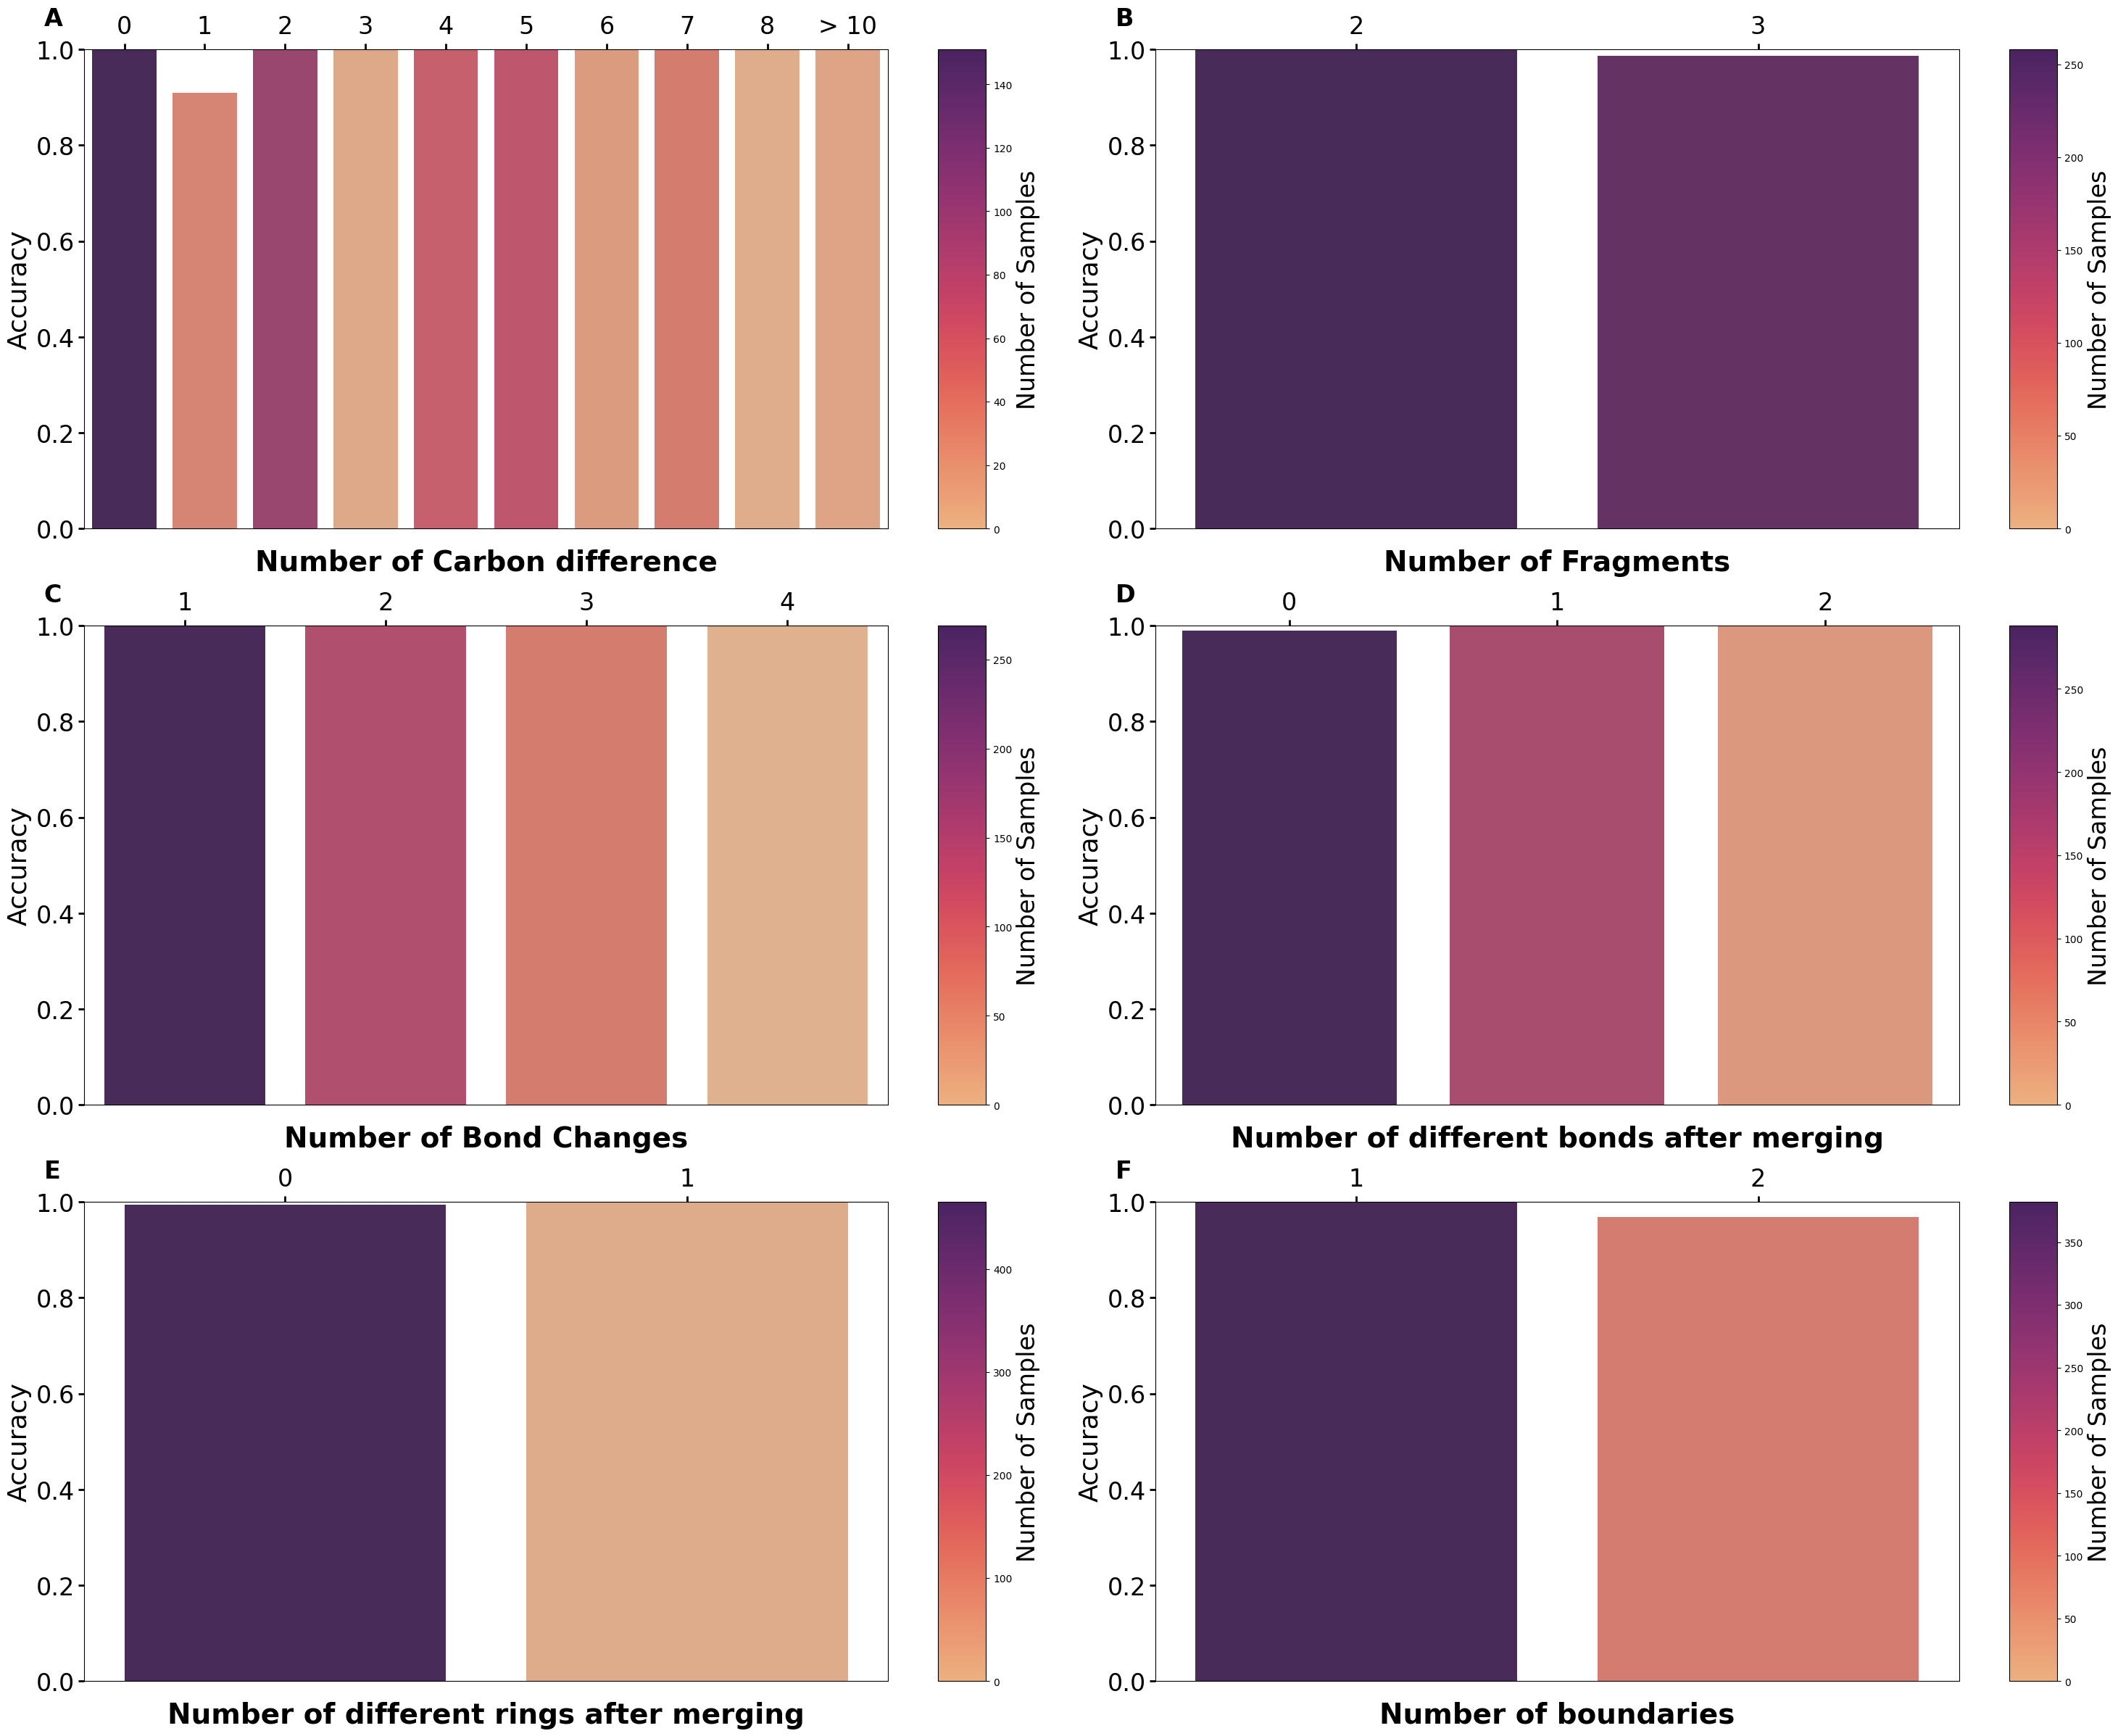

In [31]:
#from SynAnalysis.analysis_process import AnalysisProcess
#list_data_all = ['golden_dataset', 'Jaworski', 'USPTO_random_class', 'USPTO_diff', 'USPTO_unbalance_class']
list_data_all = ['USPTO_random_class']
pipeline_path = '../../../Pipeline'
data_path = '../../../Data'
for list_data in list_data_all:
    process = AnalysisProcess([list_data], pipeline_path, data_path)
    data = process.process_and_combine_datasets(remove_undetected=True)
    data_all = process.standardize_columns(data)
    from SynAnalysis.eda_analysis import EDAVisualizer

    columns = ['carbon_difference', 'fragment_count', 'Bond Changes', 'bond_change_merge', 'ring_change_merge', 'num_boundary']
    titles = ['Number of Carbon difference', 'Number of Fragments', 'Number of Bond Changes', 'Number of different bonds after merging', 
            'Number of different rings after merging', 'Number of boundaries']
    visualizer = EDAVisualizer(data_all, columns, titles)
    visualizer.visualize_accuracy(chart_type='bar', show_values=False, error_bar=False, save_path=f'./{list_data}_EDA.pdf')

In [27]:
data_all.describe(include='all')

,R-id,reactions,carbon_difference,fragment_count,total_carbons,total_bonds,total_rings,Index,Result,Bond Changes,mcs_carbon_balanced,num_boundary,ring_change_merge,bond_change_merge
count,255,255,255.0,255.0,255.000000,255.000000,255.000000,255.000000,255,255.0,255,255.000000,255.000000,255.0
unique,255,255,9.0,2.0,NaN,NaN,NaN,NaN,2,5.0,1,NaN,NaN,3.0
top,USPTO_unbalance_class_0,CCOC(=O)c1nc(-c2ccccc2)cs1>>O=C(O)c1nc(-c2cccc...,2.0,3.0,NaN,NaN,NaN,NaN,True,1.0,True,NaN,NaN,0.0
freq,1,1,56.0,210.0,NaN,NaN,NaN,NaN,247,179.0,255,NaN,NaN,222.0
mean,NaN,NaN,NaN,NaN,41.039216,5.921569,0.435294,127.113725,NaN,NaN,NaN,1.184314,0.121569,NaN
std,NaN,NaN,NaN,NaN,15.877683,3.313318,0.496770,73.943682,NaN,NaN,NaN,0.408267,0.327430,NaN
min,NaN,NaN,NaN,NaN,8.000000,1.000000,0.000000,0.000000,NaN,NaN,NaN,1.000000,0.000000,NaN
25%,NaN,NaN,NaN,NaN,29.500000,3.000000,0.000000,63.500000,NaN,NaN,NaN,1.000000,0.000000,NaN
50%,NaN,NaN,NaN,NaN,39.000000,7.000000,0.000000,127.000000,NaN,NaN,NaN,1.000000,0.000000,NaN
75%,NaN,NaN,NaN,NaN,50.000000,9.000000,1.000000,190.500000,NaN,NaN,NaN,1.000000,0.000000,NaN


In [29]:
data['fragment_count'].value_counts()

fragment_count
3    210
2     45
Name: count, dtype: int64

In [ ]:
==================================================================================
Dataset                     Reactions      Rule Suc.       MCS
Suc.       MCS Acc.
----------------------------------------------------------------------------------
Jaworski                   637 ( 335)    181  89.60%    127 82.47%   
121  95.28%
golden_dataset            1851 (1642)    754  93.55%    721 81.19%   
588  81.55%
USPTO_unbalance_class      540 ( 540)    240  97.96%    298 99.33%   
289  96.98%
USPTO_random_class         803 ( 803)    324  99.69%    479 100.00%   
476  99.37%
USPTO_diff                1589 (1589)   1134  96.10%    451 99.12%   
437  96.90%

In [81]:
import numpy as np
data = {
    "Dataset": ["Jaworski", "Golden dataset", "$\mathcal{U}_{\mathrm{Unbalance}}$", "$\mathcal{U}_{\mathrm{Random}}$", "$\mathcal{U}_{\mathrm{Diff}}$"],

    "Reactions": [637, 1851, 540, 803, 1589],
    "Unbalance": [335, 1642, 540, 803, 1589],
    "Rule_Suc": [181, 754, 240, 324, 1134],
    "Rule_Suc_Percentage": [89.60, 93.55, 97.96, 99.69, 96.10],
    "Rule_Acc": [181, 754, 240, 324, 1134],
    "Rule_Acc_Percentage": [89.60, 93.55, 97.96, 99.69, 96.10],
    "MCS_Suc": [127, 721, 298, 479, 451],
    "MCS_Suc_Percentage": [82.47, 81.19, 99.33, 100.00, 99.12],
    "MCS_Acc": [121, 588, 289, 476, 437],
    "MCS_Acc_Percentage": [95.28, 81.55, 96.98, 99.37, 96.90]
}

# Convert the dictionary to pandas DataFrame for further analysis
import pandas as pd

df = pd.DataFrame(data)
df['Rule_Suc_Percentage'] = df['Rule_Suc_Percentage'] /100
df['Rule_Acc_Percentage'] = np.array([98.90, 99.73, 99.58, 99.38, 99.91])/100
df['Rule_Acc'] = np.array([179, 752, 239, 322, 1133])


df['MCS_Suc_Percentage'] = df['MCS_Suc_Percentage'] /100
df['MCS_Acc_Percentage'] = df['MCS_Acc_Percentage'] /100

df['All_Suc'] = df['Rule_Suc'] + df['MCS_Suc']
df['All_Suc_Percentage'] = df['All_Suc'] / df['Unbalance']
df['All_Acc'] = df['Rule_Acc'] + df['MCS_Acc']
df['All_Acc_Percentage'] = df['All_Acc'] / df['All_Suc'] 
df

,Dataset,Reactions,Unbalance,Rule_Suc,Rule_Suc_Percentage,Rule_Acc,Rule_Acc_Percentage,MCS_Suc,MCS_Suc_Percentage,MCS_Acc,MCS_Acc_Percentage,All_Suc,All_Suc_Percentage,All_Acc,All_Acc_Percentage
0,Jaworski,637,335,181,0.8960,179,0.9890,127,0.8247,121,0.9528,308,0.919403,300,0.974026
1,Golden dataset,1851,1642,754,0.9355,752,0.9973,721,0.8119,588,0.8155,1475,0.898295,1340,0.908475
2,$\mathcal{U}_{\mathrm{Unbalance}}$,540,540,240,0.9796,239,0.9958,298,0.9933,289,0.9698,538,0.996296,528,0.981413
3,$\mathcal{U}_{\mathrm{Random}}$,803,803,324,0.9969,322,0.9938,479,1.0000,476,0.9937,803,1.000000,798,0.993773
4,$\mathcal{U}_{\mathrm{Diff}}$,1589,1589,1134,0.9610,1133,0.9991,451,0.9912,437,0.9690,1585,0.997483,1570,0.990536


In [84]:
df['Sample_rule'] = np.round(df['Rule_Suc'] / df['Rule_Suc_Percentage'],0)
df['Sample_mcs'] = np.round(df['MCS_Suc'] / df['MCS_Suc_Percentage'],0)
df['Sample_mcs']


0    154.0
1    888.0
2    300.0
3    479.0
4    455.0
Name: Sample_mcs, dtype: float64

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportion_confint
import numpy as np
import matplotlib.colors as mcolors
from typing import List, Optional
from rdkit import Chem
from rdkit.Chem import Draw
from matplotlib.gridspec import GridSpec
import re
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score



def barplot_accuracy_comparison(
    dfs: List[pd.DataFrame], 
    layout: str = 'vertical', 
    show_values: bool = False, 
    title_names: List[str] = ['Rule-based', 'MCS-based', 'Overall'],
    save_path: Optional[str] = None
) -> None:
    """
    Generates bar plots comparing accuracy and success rates from given DataFrames.

    Parameters:
    - dfs: List of pandas DataFrames with columns ['Dataset', 'Success Rate', 'Accuracy', 'Unbalance'].
    - layout: Plot layout, either 'vertical' or 'horizontal'. Default is 'vertical'.
    - show_values: Flag to show values on top of bars. Default is False.
    - title_names: List of titles for each subplot. Default is ['Rule-based', 'MCS-based', 'Overall'].
    - save_path: Path to save the figure. If None, the figure is not saved. Default is None.
    
    Returns:
    None
    """
    if layout not in ['vertical', 'horizontal']:
        raise ValueError("Layout must be 'vertical' or 'horizontal'")
    
    fig, axs = plt.subplots(3 if layout == 'vertical' else 1, 1 if layout == 'vertical' else 3, figsize=(14, 28) if layout == 'vertical' else (28, 9))
    axs = np.array(axs).reshape(-1)  # Ensure axs is a flat array for consistent indexing
    labels = ['A', 'B', 'C']

    for i, df in enumerate(dfs):
        ax = axs[i]
        datasets, success_rate, accuracy, unbalance = df['Dataset'], df['Success Rate'], df['Accuracy'], df['Unbalance']
        successes = np.round(unbalance * success_rate).astype(int)
        accuracies = np.round(successes * accuracy).astype(int)
        
        confint_success = proportion_confint(successes, unbalance, method='wilson')
        confint_accuracy = proportion_confint(accuracies, successes, method='wilson')
        
        error_success = np.maximum(success_rate - confint_success[0], confint_success[1] - success_rate)
        error_accuracy = np.maximum(accuracy - confint_accuracy[0], confint_accuracy[1] - accuracy)
        
        cmap = plt.get_cmap('flare')  # Adjusted for compatibility
        color_for_success_rate, color_for_accuracy = cmap(0.3), cmap(0.7)
        
        bar_width, index = 0.35, np.arange(len(datasets))
        bars1 = ax.bar(index - bar_width/2, success_rate*100, bar_width, yerr=error_success.T*100, capsize=5, label='Success Rate', color=color_for_success_rate, error_kw={'ecolor':'black', 'elinewidth':2})
        bars2 = ax.bar(index + bar_width/2, accuracy*100, bar_width, yerr=error_accuracy.T*100, capsize=5, label='Accuracy', color=color_for_accuracy, error_kw={'ecolor':'black', 'elinewidth':2})
        
        ax.set_ylabel('Percentage (%)', fontsize=18)
        ax.set_xticks(index)
        ax.set_xticklabels(datasets, rotation=45, ha='right', fontsize=16)
        ax.set_ylim(0, 105)
        ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('grey')
        ax.spines['bottom'].set_color('grey')
        ax.set_title(title_names[i], fontsize=24, fontweight='bold')
        ax.text(-0.05, 1.0, labels[i], transform=ax.transAxes, size=8, weight='bold')
        
        if show_values:
            for bars in [bars1, bars2]:
                for bar in bars:
                    height = bar.get_height()
                    if height == 100:
                        ax.annotate(f'{height:.0f}%', xy=(bar.get_x() + bar.get_width() / 2, height*1.02), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=12)
                    else:
                        ax.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height*1.02), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=12)
    
    fig.legend(['Success Rate', 'Accuracy'], loc='lower left', bbox_to_anchor=(0.85, 0.95), fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(right=0.78 if layout == 'vertical' else 0.9)

    if save_path:
        plt.savefig(save_path, dpi=600, transparent=True)
    plt.show()

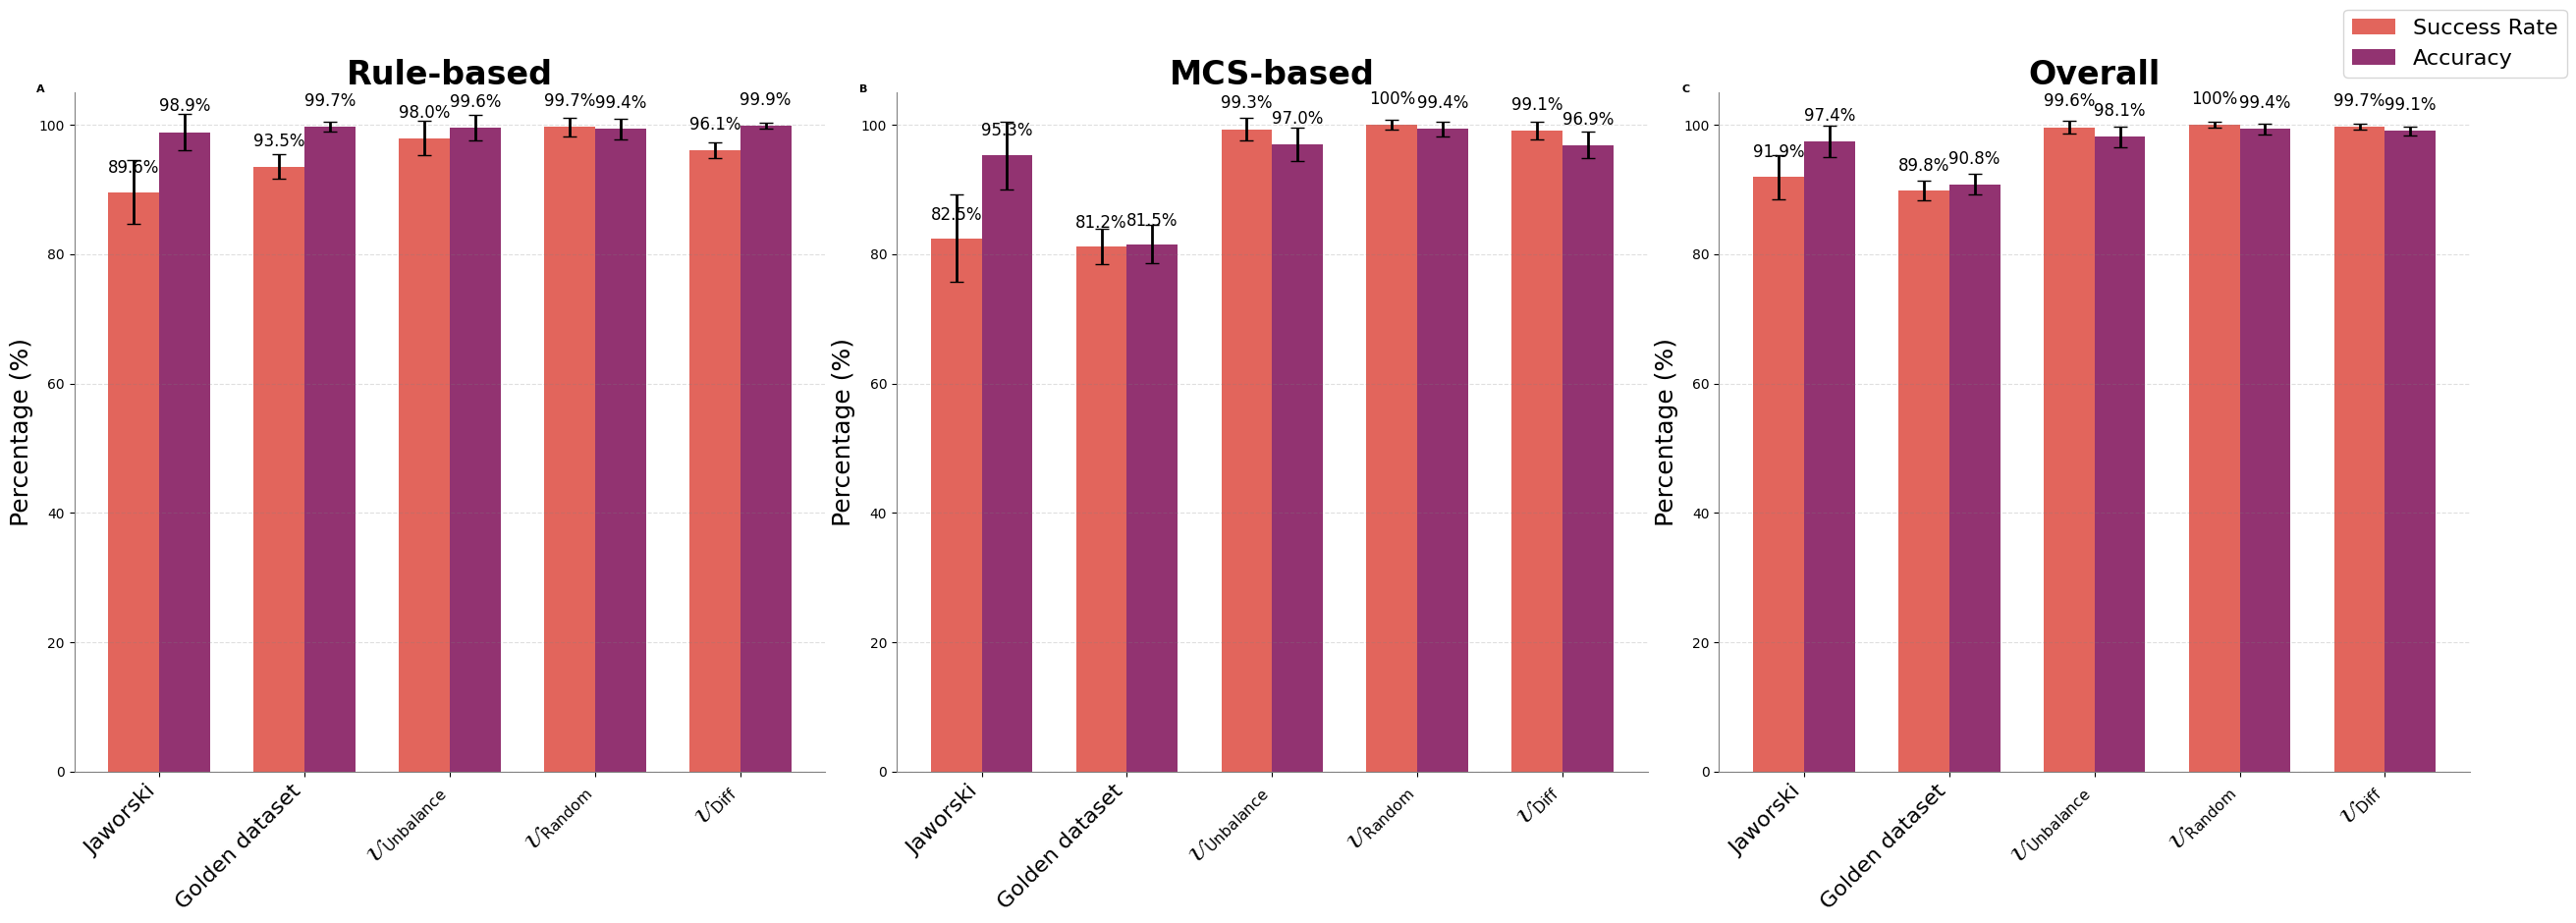

In [107]:
#from SynAnalysis.visualizer import barplot_accuracy_comparison
rule_based = df[['Dataset', 'Rule_Suc_Percentage', 'Rule_Acc_Percentage', 'Sample_rule']].rename(columns={'Rule_Suc_Percentage': 'Success Rate', 'Rule_Acc_Percentage': 'Accuracy', 'Sample_rule': 'Unbalance'})
mcs_based = df[['Dataset', 'MCS_Suc_Percentage', 'MCS_Acc_Percentage', 'Sample_mcs']].rename(columns={'MCS_Suc_Percentage': 'Success Rate', 'MCS_Acc_Percentage': 'Accuracy', 'Sample_mcs': 'Unbalance'})
all_data = df[['Dataset', 'All_Suc_Percentage', 'All_Acc_Percentage', 'Unbalance']].rename(columns={'All_Suc_Percentage': 'Success Rate', 'All_Acc_Percentage': 'Accuracy'})
barplot_accuracy_comparison([rule_based, mcs_based, all_data], layout='horizontal', show_values=True, save_path='accuracy_bar_plot.pdf')

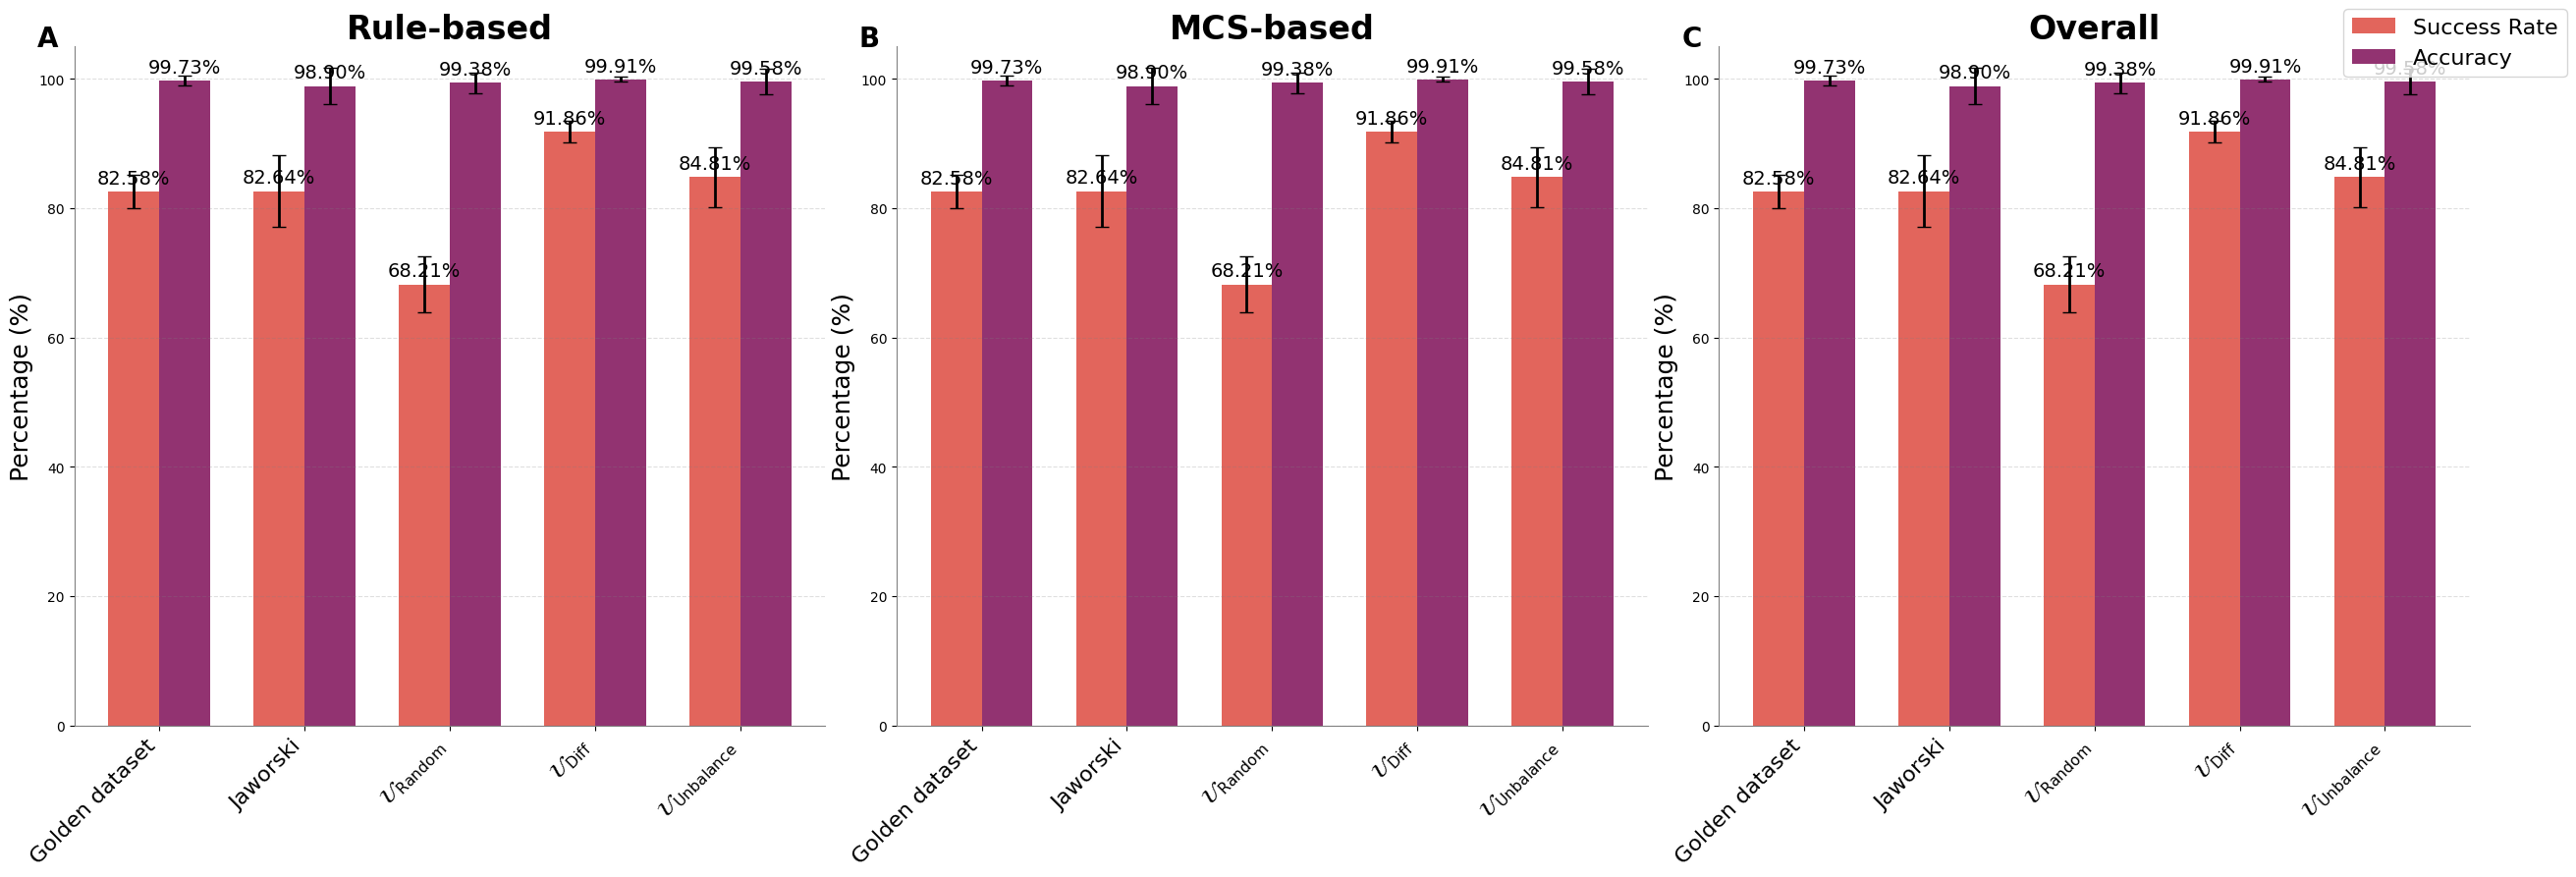

In [32]:
import pandas as pd
import numpy as np
datasets = ["Golden dataset", "Jaworski", "$\mathcal{U}_{\mathrm{Random}}$", "$\mathcal{U}_{\mathrm{Diff}}$", "$\mathcal{U}_{\mathrm{Unbalance}}$"]
success_rate = np.array([82.58, 82.64, 68.21, 91.86, 84.81]) / 100  # Convert to proportions
accuracy = np.array([99.73, 98.90, 99.38, 99.91, 99.58]) / 100  # Convert to proportions
unbalance = np.array([913, 219, 475, 1253, 283])
data = pd.DataFrame({'Dataset': datasets, 'Success Rate': success_rate, 'Accuracy': accuracy, 'Unbalance': unbalance})
from SynAnalysis.visualizer import barplot_accuracy_comparison
barplot_accuracy_comparison([data,data,data], layout='horizontal', show_values=True, save_path='accuracy_bar_plot.pdf')


In [21]:
df['All_Acc'].sum() / df['Unbalance'].sum()

0.9240171114279894

In [18]:
df['All_Suc_Percentage']

0    0.919403
1    0.898295
2    0.996296
3    1.000000
4    0.997483
Name: All_Suc_Percentage, dtype: float64

In [22]:
import numpy as np
datasets = ["Golden dataset", "Jaworski", "$\mathcal{U}_{\mathrm{Random}}$", "$\mathcal{U}_{\mathrm{Diff}}$", "$\mathcal{U}_{\mathrm{Unbalance}}$"]
success_rate = np.array([93.55, 89.60, 68.21, 91.86, 84.81]) / 100  # Convert to proportions
accuracy = np.array([99.73, 98.90, 99.38, 99.91, 99.58]) / 100  # Convert to proportions
unbalance = np.array([913, 219, 475, 1253, 283])
data = pd.DataFrame({'Dataset': datasets, 'Success Rate': success_rate, 'Accuracy': accuracy, 'Unbalance': unbalance})

In [23]:
data

,Dataset,Success Rate,Accuracy,Unbalance
0,Golden dataset,0.9355,0.9973,913
1,Jaworski,0.8960,0.9890,219
2,$\mathcal{U}_{\mathrm{Random}}$,0.6821,0.9938,475
3,$\mathcal{U}_{\mathrm{Diff}}$,0.9186,0.9991,1253
4,$\mathcal{U}_{\mathrm{Unbalance}}$,0.8481,0.9958,283


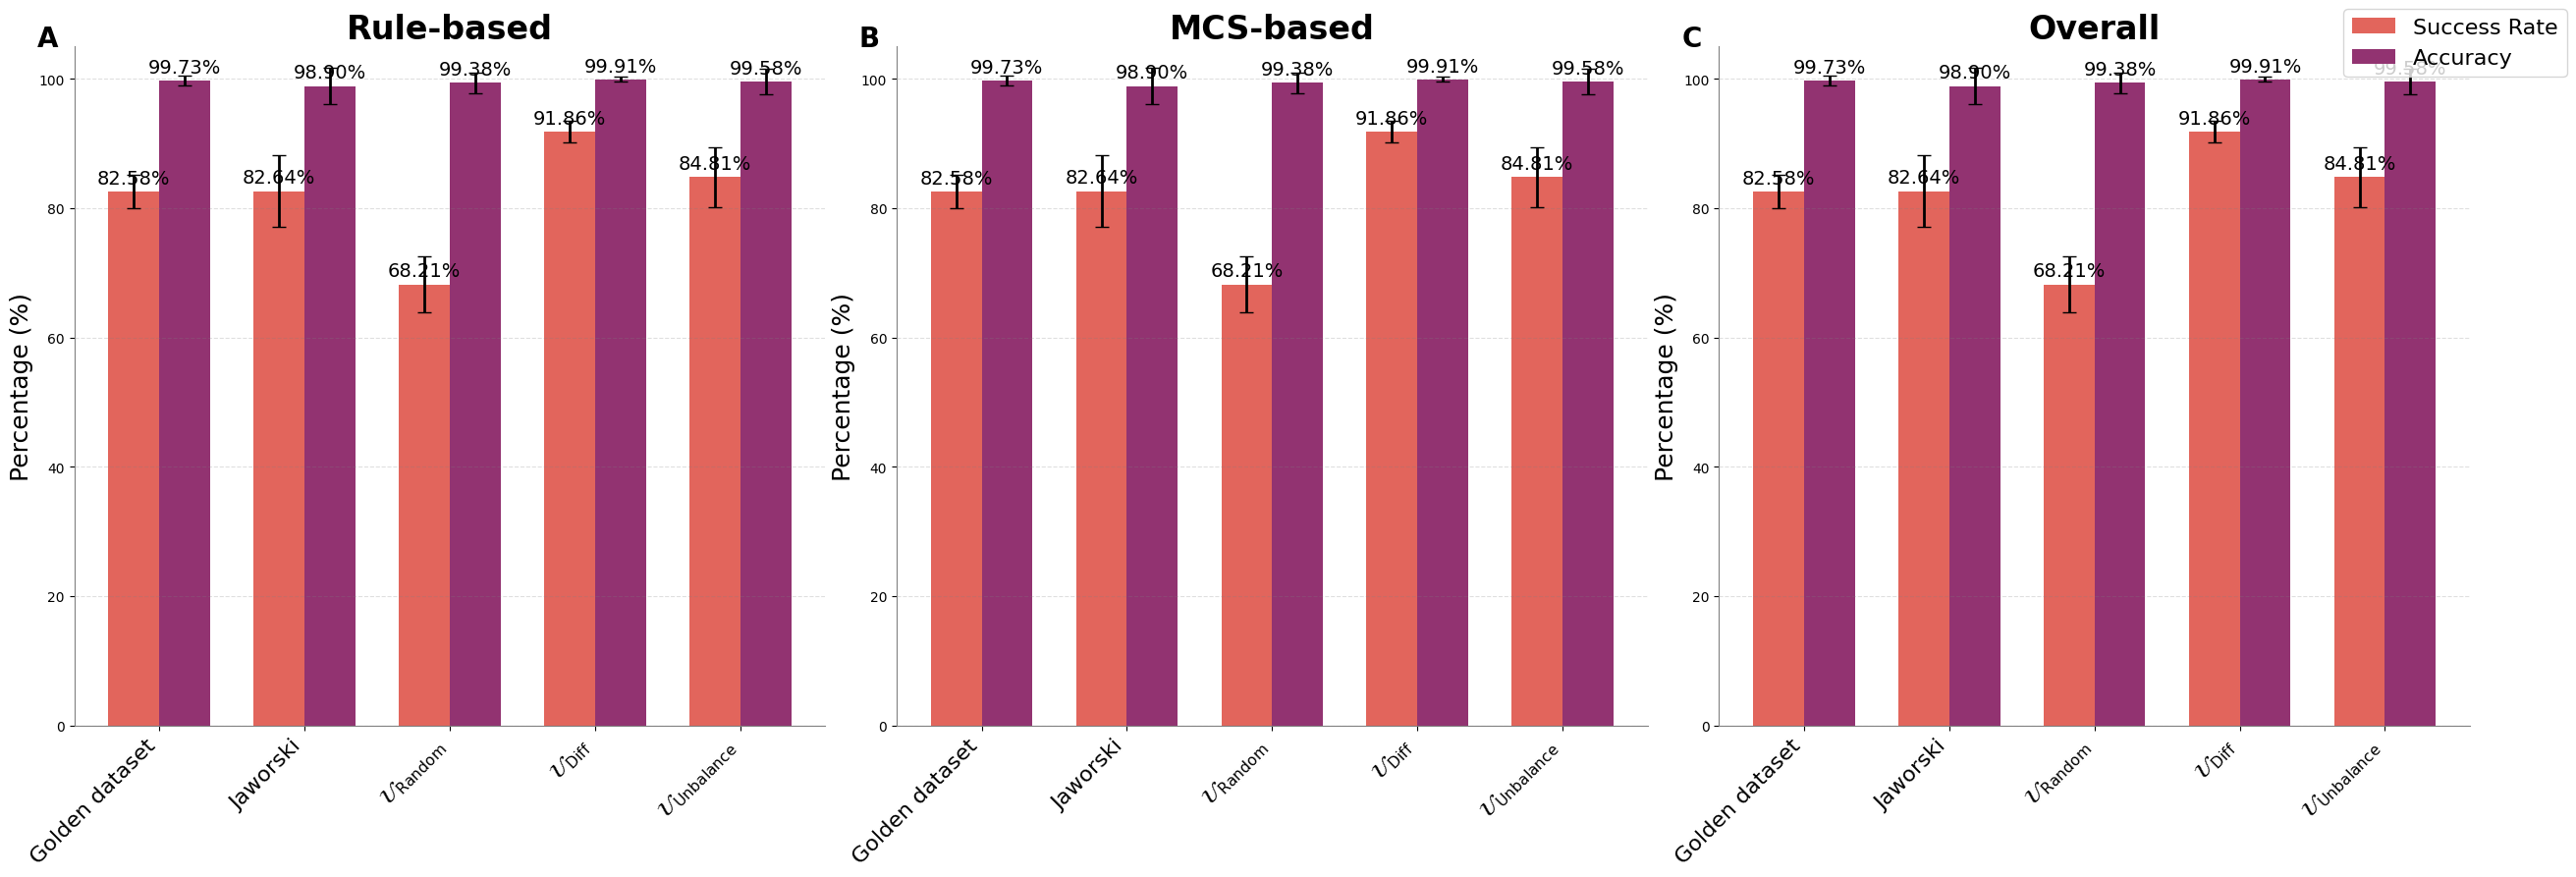

In [3]:
import pandas as pd
import numpy as np
datasets = ["Golden dataset", "Jaworski", "$\mathcal{U}_{\mathrm{Random}}$", "$\mathcal{U}_{\mathrm{Diff}}$", "$\mathcal{U}_{\mathrm{Unbalance}}$"]
success_rate = np.array([82.58, 82.64, 68.21, 91.86, 84.81]) / 100  # Convert to proportions
accuracy = np.array([99.73, 98.90, 99.38, 99.91, 99.58]) / 100  # Convert to proportions
unbalance = np.array([913, 219, 475, 1253, 283])
data = pd.DataFrame({'Dataset': datasets, 'Success Rate': success_rate, 'Accuracy': accuracy, 'Unbalance': unbalance})
from SynAnalysis.visualizer import barplot_accuracy_comparison
barplot_accuracy_comparison([data,data,data], layout='horizontal', show_values=True, save_path='accuracy_bar_plot.pdf')


In [95]:
from SynRBL.SynMCSImputer.SubStructure.mcs_process import ensemble_mcs
from SynRBL.SynUtils.data_utils import load_database, save_database
from SynRBL.SynMCSImputer.SubStructure.extract_common_mcs import ExtractMCS
from SynRBL.SynMCSImputer.MissingGraph.find_graph_dict import find_graph_dict
from SynRBL.SynMCSImputer.MissingGraph.refinement_uncertainty import RefinementUncertainty

mcs1 = load_database('../../../Data/Validation_set/golden_dataset/MCS/Condition_1.json.gz')
mcs2 = load_database('../../../Data/Validation_set/golden_dataset/MCS/Condition_2.json.gz')
mcs3 = load_database('../../../Data/Validation_set/golden_dataset/MCS/Condition_3.json.gz')
mcs4 = load_database('../../../Data/Validation_set/golden_dataset/MCS/Condition_4.json.gz')
mcs5 = load_database('../../../Data/Validation_set/golden_dataset/MCS/Condition_5.json.gz')
datasets = ["Configuration 1", "Configuration 2", "Configuration 3", "Configuration 4", "Configuration 5", 'Ensemble']
golden = [256, 279, 211, 269, 398, 195]
jaworski = [26, 30, 22, 33, 46, 21]
random = [66, 80, 60, 75, 203, 60]
diff = [44, 50, 42, 45, 128, 40]
unbalance = [37, 37, 33, 35, 130, 33]

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data
data = {
    "Configuration": ["Configuration 1", "Configuration 2", "Configuration 3", "Configuration 4", "Configuration 5", 'Ensemble'] * 5,
    "Dataset": ["Golden dataset"] * 6 + ["Jaworski"] * 6 + ["$\mathcal{U}_{\mathrm{Random}}$"] * 6 + ["$\mathcal{U}_{\mathrm{Diff}}$"] * 6 + ["$\mathcal{U}_{\mathrm{Unbalance}}$"] * 6,
    "Value": [256, 279, 211, 269, 398, 195, 26, 30, 22, 33, 46, 21, 66, 80, 60, 75, 203, 60, 44, 50, 42, 45, 128, 40, 37, 37, 33, 35, 130, 33]
}

df = pd.DataFrame(data)


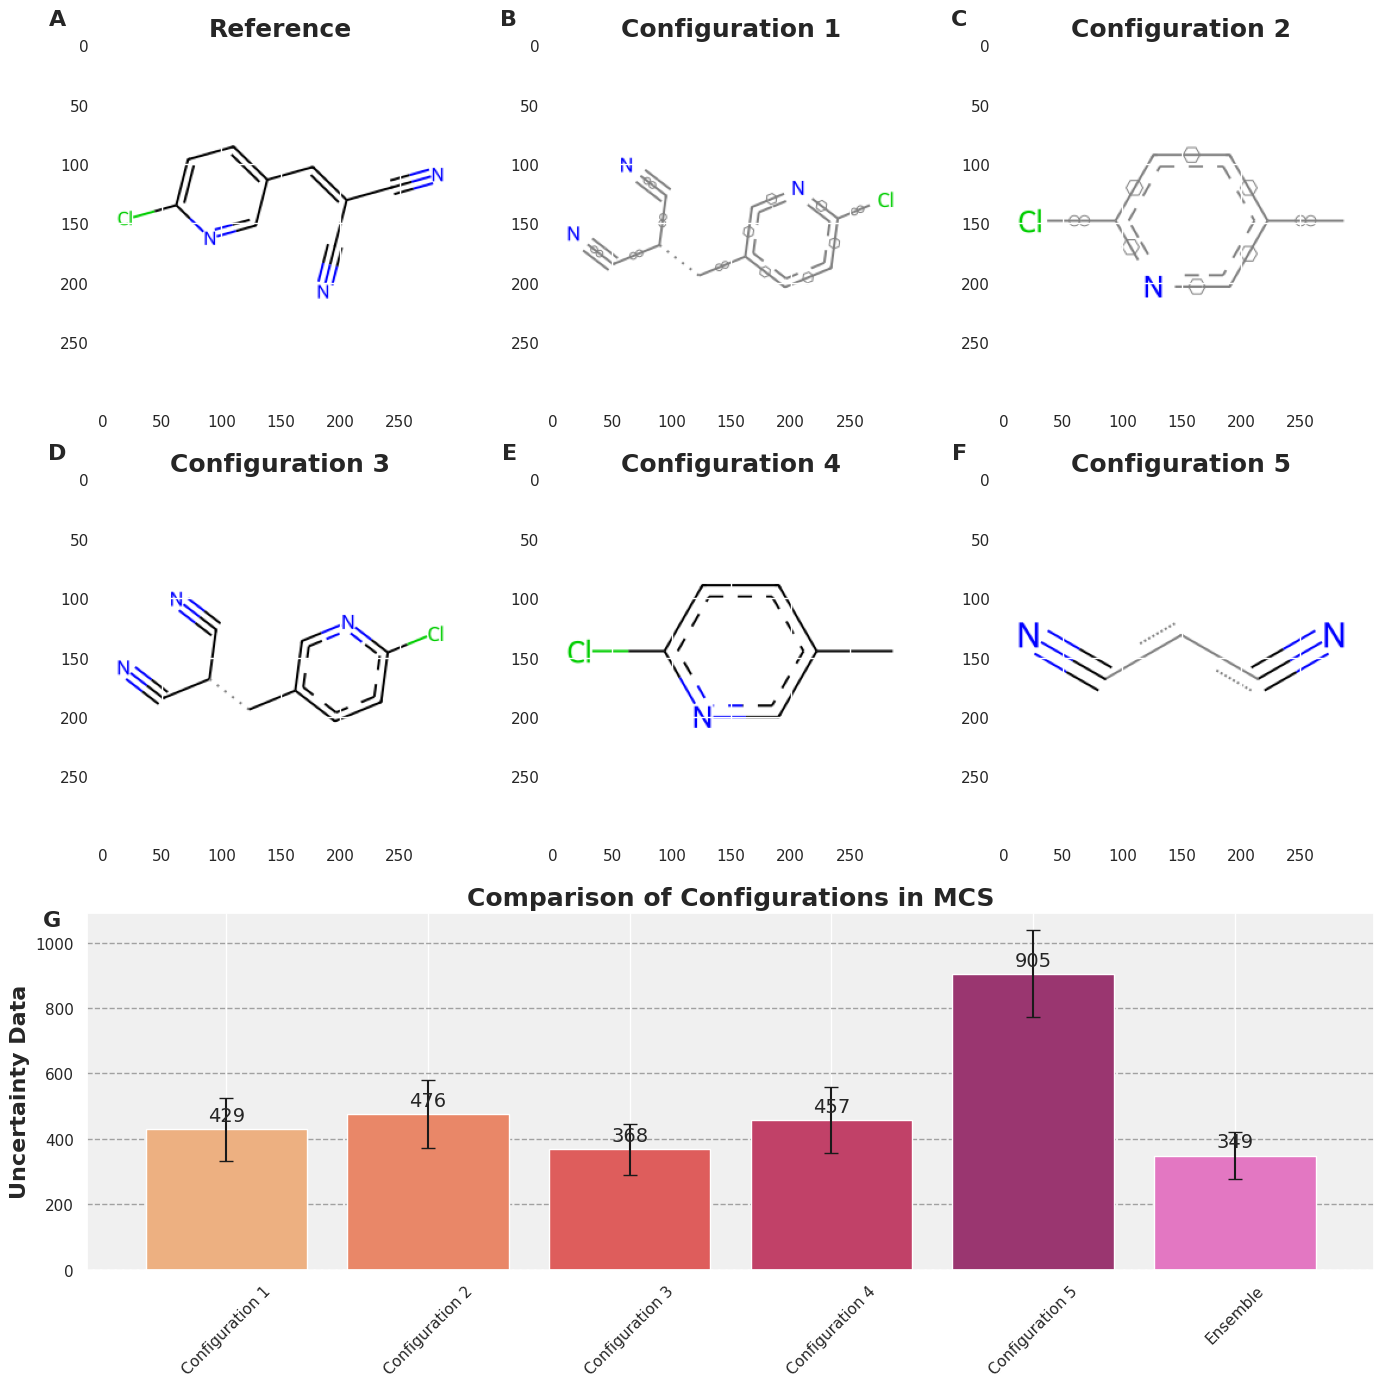

In [105]:
from SynAnalysis.visualizer import mcs_comparsion
mcs_comparsion([mcs1, mcs1, mcs2, mcs3, mcs4, mcs5], df, 67, save_path='./comparison_mcs.pdf')

In [ ]:
from SynAnalysis.visualizer import mcs_comparsion
mcs_comparsion([mcs1, mcs1, mcs2, mcs3, mcs4, mcs5], df, 67, save_path='./comparison_mcs.pdf')

In [97]:

list_data = ['golden_dataset', 'Jaworski', 'USPTO_random_class', 'USPTO_diff', 'USPTO_unbalance_class']
pipeline_path = '../../../Pipeline'
data_path = '../../../Data'
process = AnalysisProcess(list_data, pipeline_path, data_path)

data_check = process.process_and_combine_datasets(remove_undetected=False).drop(['R-id', 'reactions','Index', 'mcs_carbon_balanced'], axis =1)



PermissionError: [Errno 13] Permission denied: '/fearure_importance.png'

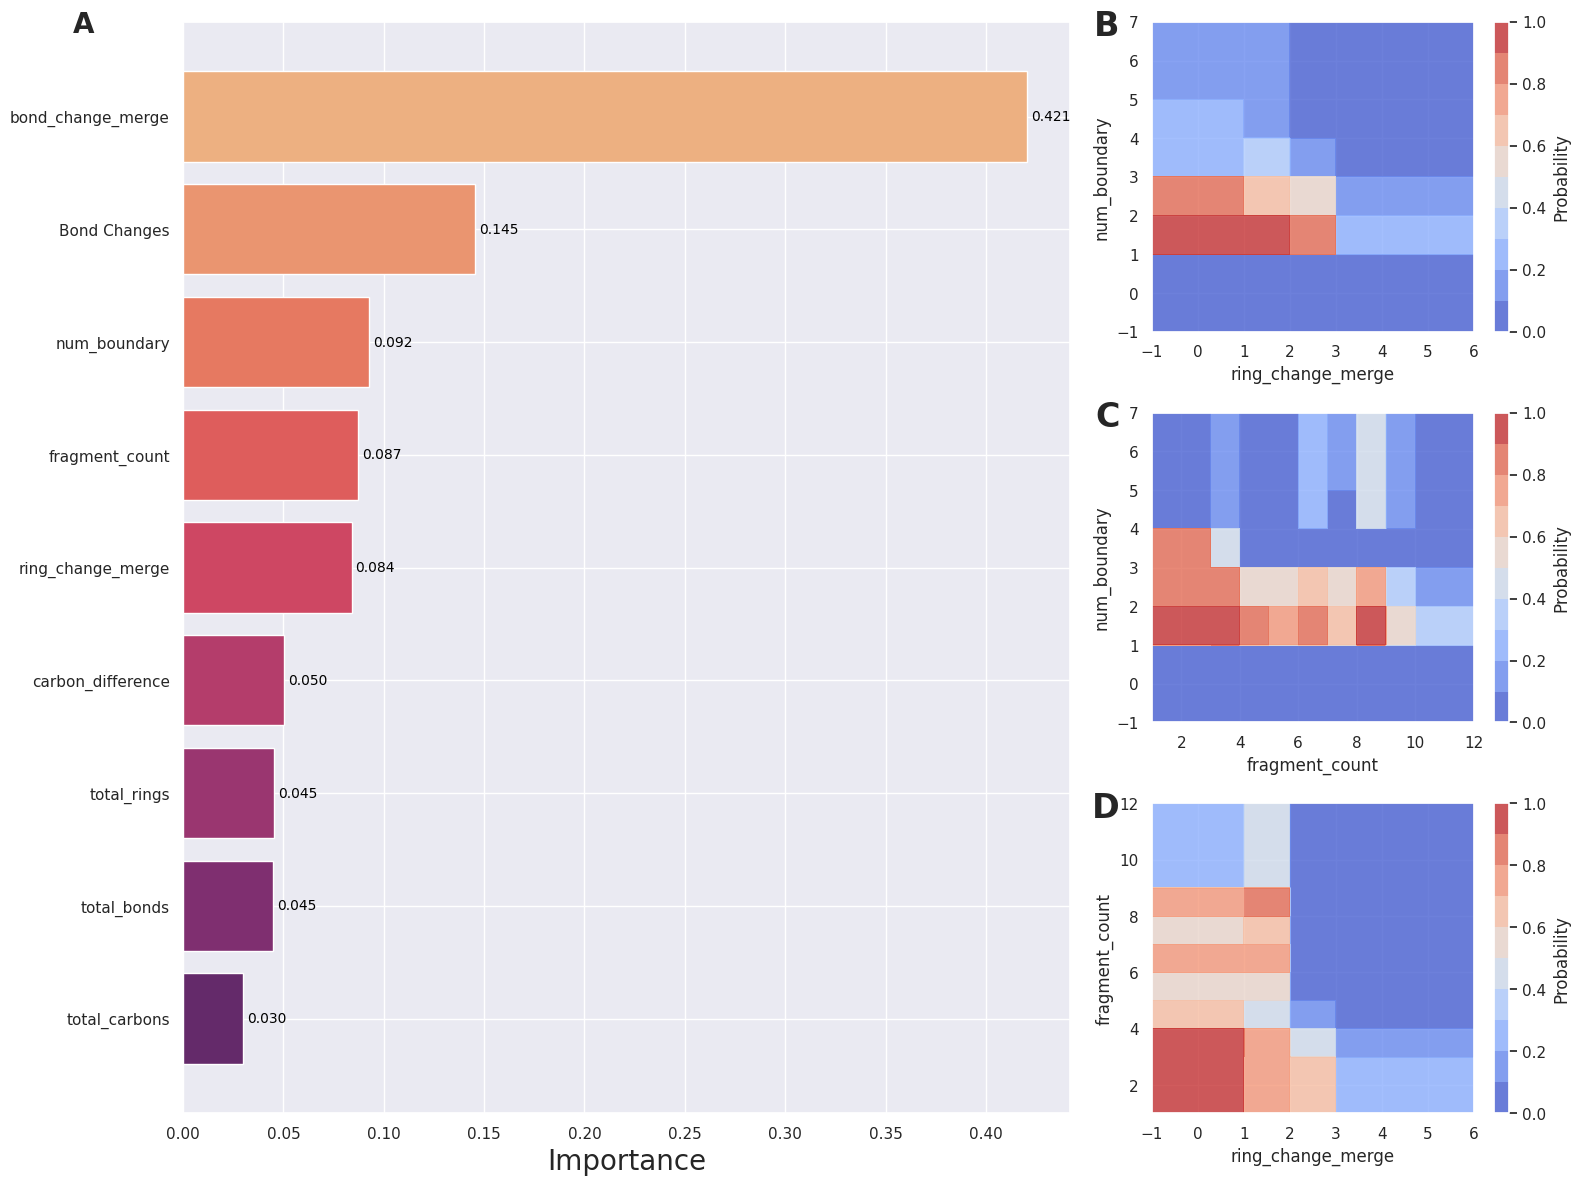

In [98]:
from SynAnalysis.feature_analysis import FeatureAnalysis
vis = FeatureAnalysis(data_check, 'Result', [('ring_change_merge','num_boundary'),
                                           ('fragment_count','num_boundary'), 
                                           ('ring_change_merge','fragment_count')])
vis.visualize(save_path='/fearure_importance.png')

In [102]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline as Pipeline
from SynAnalysis.analysis_process import AnalysisProcess
import pickle
list_data = ['golden_dataset', 'Jaworski', 'USPTO_random_class', 'USPTO_diff', 'USPTO_unbalance_class']
pipeline_path = '../../../Pipeline'
data_path = '../../../Data'
process = AnalysisProcess(list_data, pipeline_path, data_path)
data_raw = process.process_and_combine_datasets(remove_undetected=False).drop(['R-id', 'reactions', 'Bond Changes',
                                                                                'Index', 'mcs_carbon_balanced'], axis =1)

data_raw = data_raw.drop_duplicates()
X, y = data_raw.drop('Result', axis=1), data_raw['Result']

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

steps = [('scaler', MinMaxScaler()), ('over', SMOTETomek(sampling_strategy='minority', random_state=42)), ('model', XGBClassifier(random_state=42,))]
pipeline = Pipeline(steps=steps)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

with open('scoring_function.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.78      0.77        68
           1       0.94      0.93      0.94       240

    accuracy                           0.90       308
   macro avg       0.85      0.86      0.85       308
weighted avg       0.90      0.90      0.90       308



In [103]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportion_confint
import numpy as np
import matplotlib.colors as mcolors
from typing import List, Optional
from rdkit import Chem
from rdkit.Chem import Draw
from matplotlib.gridspec import GridSpec
import re
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score

def classification_visualization(y_true: np.ndarray, y_pred: np.ndarray, y_proba: np.ndarray, save_path: str = None, figsize: tuple = (14, 14)):
    """
    Visualize classification metrics including Confusion Matrix, Classification Report, ROC Curve, and Precision-Recall Curve.

    Parameters:
    y_true (np.ndarray): True labels.
    y_pred (np.ndarray): Predicted labels.
    y_proba (np.ndarray): Predicted probabilities.
    save_path (str, optional): Path to save the figure. If None, the figure is not saved. Default is None.
    figsize (tuple, optional): Figure size (width, height). Default is (14, 14).

    Returns:
    None
    """
    # Setup the matplotlib figure and axes, 2x2 layout
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    #fig.suptitle('Advanced Classification Metrics Visualization', fontsize=16)

    labels = ['A', 'B', 'C', 'D']  # Labels for each subplot
    for ax, label in zip(axes.flat, labels):
        ax.text(-0.1, 1.1, label, transform=ax.transAxes, size=20, weight='bold', va='top', ha='right')

    # Subfig 1: Confusion Matrix
    ax = axes[0, 0]
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, annot_kws={"size": 14})
    ax.set(xlabel='Predicted labels', ylabel='True labels')
    ax.set_title('Confusion Matrix', fontsize=18, weight='bold', pad=20)

    # Subfig 2: Classification Report
    ax = axes[0, 1]
    report = classification_report(y_true, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    sns.heatmap(report_df.iloc[:-1, :].astype(float), annot=True, cmap='Spectral', cbar=True, fmt=".2f", ax=ax, annot_kws={"size": 14})
    ax.set_title('Classification Report', fontsize=18, weight='bold', pad=20)

    # Enhance ROC Curve visual
    ax = axes[1, 0]
    fpr, tpr, thresholds = roc_curve(y_true, y_proba[:, 0], pos_label=0)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc, color='darkorange', lw=2)
    ax.fill_between(fpr, tpr, color='darkorange', alpha=0.3)
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='navy')
    ax.set(xlim=[0.0, 1.0], ylim=[0.0, 1.05], xlabel='False Positive Rate', ylabel='True Positive Rate')
    ax.set_title('ROC Curve', fontsize=18, weight='bold', pad=20)

    ax.legend(loc="lower right")

    # Enhance Precision-Recall Curve visual
    ax = axes[1, 1]
    precision, recall, _ = precision_recall_curve(y_true, y_proba[:,0], pos_label=0)
    average_precision = average_precision_score(y_true, y_proba[:,0], pos_label=0)
    ax.plot(recall, precision, label='Precision-Recall curve (AP = %0.2f)' % average_precision, color='blue', lw=2)
    ax.fill_between(recall, precision, color='blue', alpha=0.3)
    ax.set(xlim=[0.0, 1.0], ylim=[0.0, 1.05], xlabel='Recall', ylabel='Precision')
    ax.set_title('Precision-Recall Curve', fontsize=18, weight='bold', pad=20)

    ax.legend(loc="lower left")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    if save_path:
        plt.savefig(save_path, dpi=600, transparent=True, bbox_inches='tight')
    plt.show()

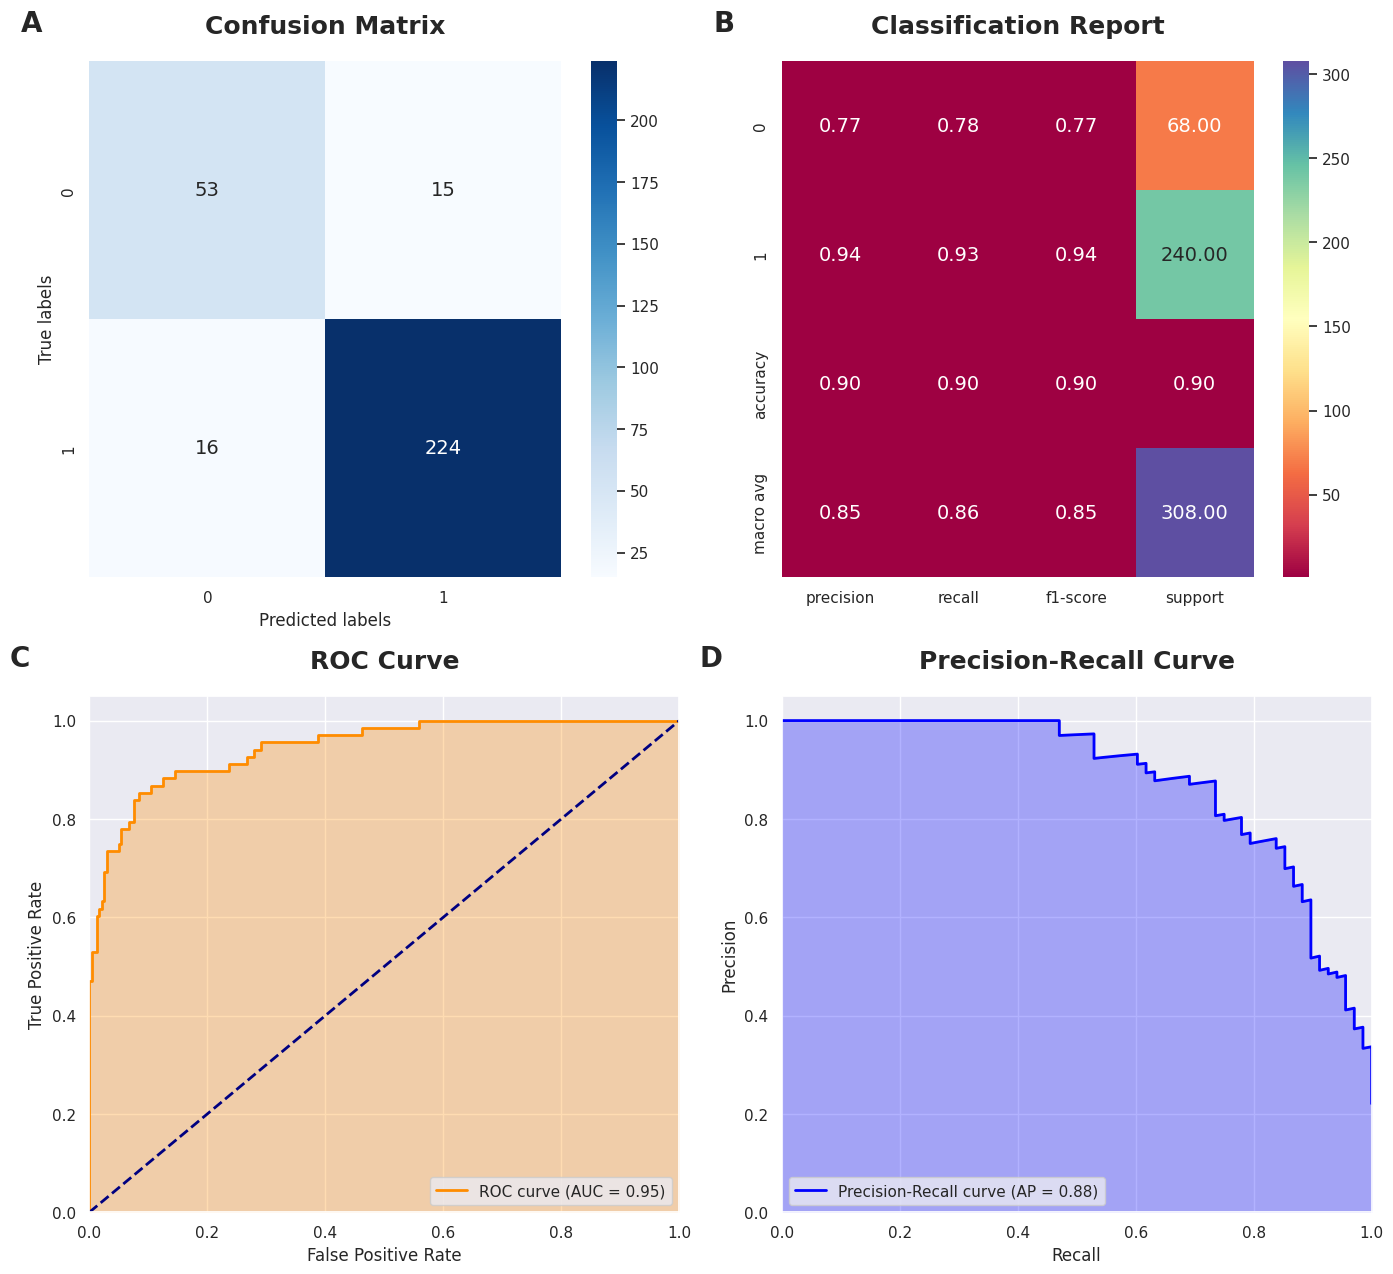

In [104]:
#from SynAnalysis.visualizer import classification_visualization

classification_visualization(y_test, y_pred, pipeline.predict_proba(X_test),
                             save_path = 'model_performance.png', figsize = (14, 14))

In [18]:
from typing import List, Union
from pandas import DataFrame
from SynRBL.rsmi_utils import load_database
import pickle
from SynAnalysis.analysis_utils import remove_atom_mapping_from_reaction_smiles, calculate_chemical_properties, count_boundary_atoms_products_and_calculate_changes
from IPython.display import clear_output
import pandas as pd
import numpy as np

def confidence_level(merge_data_path: str, mcs_data_path: str, scoring_function_path: str, remove_undetected: bool = True) -> List[float]:
    """
    Calculates the confidence level for chemical reactions based on their properties and a pre-trained model.
    
    This function loads merged and MCS (Maximum Common Substructure) reaction data, calculates various chemical
    properties, and uses a pre-trained model to predict a confidence level for each reaction.
    
    Parameters:
    - merge_data_path (str): Path to the file containing merged reaction data.
    - mcs_data_path (str): Path to the file containing MCS reaction data.
    - scoring_function_path (str): Path to the pre-trained model file (pickle format).
    - remove_undetected (bool, optional): If True, removes reactions where the MCS carbon balance is not detected. Defaults to True.
    
    Returns:
    - List[float]: A list of confidence scores for each reaction, based on the predictions from the pre-trained model.
    
    Note:
    - The function assumes that the reaction data includes specific fields such as 'R-id' for reaction ID and chemical property columns.
    - The pre-trained model should be capable of providing probability estimates through a `predict_proba` method.
    """
    
    # Load and process merge data
    merge_data = load_database(merge_data_path)
    merge_data = count_boundary_atoms_products_and_calculate_changes(merge_data)
    
    # Load and process MCS data
    mcs_data = load_database(mcs_data_path)
    id = [value['R-id'] for value in merge_data]
    mcs_data = [value for value in mcs_data if value['R-id'] in id]
    mcs_data = calculate_chemical_properties(mcs_data)
    
    # Clear output
    clear_output(wait=False)
    
    # Combine data and filter if necessary
    combined_data = pd.concat([
        pd.DataFrame(mcs_data)[['R-id', 'reactions', 'carbon_difference', 'fragment_count', 'total_carbons', 'total_bonds', 'total_rings']],
        pd.DataFrame(merge_data)[['mcs_carbon_balanced', 'num_boundary', 'ring_change_merge', 'bond_change_merge', 'new_reaction']],
    ], axis=1)
    
    # if remove_undetected:
    #     combined_data = combined_data[combined_data['mcs_carbon_balanced'] == True]
    
    combined_data = combined_data.reset_index(drop=True)
    unnamed_columns = [col for col in combined_data.columns if 'Unnamed' in col]
    combined_data = combined_data.drop(unnamed_columns, axis=1)
    
    # Prepare data for prediction
    X_pred = combined_data[['carbon_difference', 'fragment_count', 'total_carbons', 'total_bonds', 'total_rings', 'num_boundary', 'ring_change_merge', 'bond_change_merge']]
    
    # Load model and predict confidence
    with open(scoring_function_path, 'rb') as file:
        loaded_model = pickle.load(file)
    
    confidence = np.round(loaded_model.predict_proba(X_pred)[:, 1],3)
    combined_data['confidence'] = confidence
    
    return combined_data[['R-id', 'reactions', 'new_reaction', 'confidence', 'mcs_carbon_balanced']]


In [29]:
list_data_all = ['golden_dataset', 'Jaworski', 'USPTO_random_class', 'USPTO_diff', 'USPTO_unbalance_class']
data_all = pd.DataFrame()
for data_name in list_data_all:
    result_df = pd.read_csv(f'./SynRBL - {data_name}.csv')[['Result']]
    result_df.loc[result_df['Result'] == 'CONSIDER', 'Result'] = False
    result_df.loc[result_df['Result'] == 'FALSE', 'Result'] = False
    result_df.loc[result_df['Result'] == 'TRUE', 'Result'] = True
    data_pred = confidence_level(merge_data_path= f'../../../Data/Validation_set/{data_name}/MCS/MCS_Impute.json.gz', 
                              mcs_data_path = f'../../../Data/Validation_set/{data_name}/mcs_based_reactions.json.gz', 
                              scoring_function_path=f'./scoring_function.pkl', remove_undetected=True)
    data_pred=data_pred.rename(columns={'mcs_carbon_balanced': 'Success'})
    data_pred = pd.concat([data_pred, result_df], axis=1)
    data_all = pd.concat([data_all, data_pred], axis=0)
    data_all = data_all.reset_index(drop=True)

In [30]:
data_all['reactions'] = data_all['reactions'].apply(lambda x: remove_atom_mapping_from_reaction_smiles(x))
data_all = data_all.reset_index(drop=True)

[15:15:59] WARNING: not removing hydrogen atom without neighbors
[15:15:59] WARNING: not removing hydrogen atom without neighbors
[15:15:59] WARNING: not removing hydrogen atom without neighbors
[15:15:59] WARNING: not removing hydrogen atom without neighbors
[15:16:00] WARNING: not removing hydrogen atom without neighbors
[15:16:00] WARNING: not removing hydrogen atom without neighbors
[15:16:00] WARNING: not removing hydrogen atom without neighbors


In [32]:
data_all

,R-id,reactions,new_reaction,confidence,Success,Result
0,golden_dataset_1,C=CC(O)C(C)N.C=CCSCC(C)=O>>CC(=O)CSCC=CC(O)C(C)N,[CH3:1][C:2](=[O:3])[CH2:4][S:5][CH2:6][CH:7]=...,0.127,True,False
1,golden_dataset_2,C=CCC(CCC(COCc1ccccc1)O[Si](C)(C)C(C)(C)C)OS(C...,[CH3:1][C:2]([CH3:3])([CH3:4])[Si:5]([CH3:6])(...,0.996,True,True
2,golden_dataset_7,CCOC(=O)C=Cc1ccc(NCCCCCCCCCCCCCC[Si](C)(C)C)cc...,[CH3:28][Si:27]([CH3:29])([CH3:30])[CH2:26][CH...,0.999,True,True
3,golden_dataset_10,CCOC(=O)Cc1csc(-c2ccc(C(CC)(CC)c3ccc(C=CC(O)(C...,[F:34][C:33]([F:35])([F:36])[C:31]([C:37]([F:4...,0.993,True,True
4,golden_dataset_11,C=CC(C)=O.C=CCCCC>>CCCCC=CC(C)=O,[CH2:7]([CH2:8][CH2:9][CH:10]=[CH2:11])[CH3:6]...,0.151,True,False
...,...,...,...,...,...,...
2250,USPTO_unbalance_class_295,CC(C)(Cc1ccc(Cl)cc1Cl)C(=O)Cn1cncn1.C[S+](C)C>...,CC(C)(Cc1ccc(Cl)cc1Cl)C(=O)Cn1cncn1.C[S+](C)C>...,0.990,True,True
2251,USPTO_unbalance_class_296,C[S+](C)C.O=C(c1ccc(Cl)cc1)c1ccc(I)cc1>>Clc1cc...,C[S+](C)C.O=C(c1ccc(Cl)cc1)c1ccc(I)cc1>>Clc1cc...,0.726,True,True
2252,USPTO_unbalance_class_297,C[Si](C)(C)N=[N+]=[N-].N#Cc1ccc(C=O)cc1>>O=Cc1...,C[Si](C)(C)N=[N+]=[N-].N#Cc1ccc(C=O)cc1>>O=Cc1...,0.990,True,True
2253,USPTO_unbalance_class_298,COc1ccc(S(=O)(=O)N(CC#N)c2ccc(Cl)cc2C(=O)c2ccc...,COc1ccc(S(=O)(=O)N(CC#N)c2ccc(Cl)cc2C(=O)c2ccc...,0.912,True,True


In [56]:
df = data_all[['Success','Result','confidence']]

In [40]:
from copy import deepcopy

In [43]:
def sucess_rate(data):
    rate = []
    for key, value in enumerate(data['confidence']):
        data_temp = deepcopy(data)
        #data_test = data.loc[data['confidence'] >= value, :]
        data_temp.loc[data_temp['confidence'] < value, 'Success'] = False
        sucess_rate = len(data_temp.loc[data_temp['Success'] == True, :]) / len(data_temp)
        rate.append(sucess_rate)
    return rate

def accuracy_rate(data):
    rate = []
    for key, value in enumerate(data['confidence']):
        data_temp = deepcopy(data)
        #data_test = data.loc[data['confidence'] >= value, :]
        data_temp = data_temp.loc[data_temp['confidence'] >= value, :]
        accuracy_rate = len(data_temp.loc[data_temp['Result'] == True, :]) / len(data_temp)
        rate.append(sucess_rate)
    return rate

In [84]:
from copy import deepcopy
df_sorted = df.sort_values(by='confidence')
# Assuming 'data' is the DataFrame 'df'
data = deepcopy(df_sorted)  # Using df_sorted as the base data for this example

def calculate_rates(data):
    success_rates = []
    accuracy_rates = []
    unique_confidences = np.sort(data['confidence'].unique())
    
    for value in unique_confidences:
        # Mark predictions as unsuccessful if below the current threshold
        deemed_successful = data['confidence'] >= value
        success_rate = deemed_successful.mean()
        
        # For accuracy, consider only those deemed successful
        if deemed_successful.any():  # Check if there's at least one deemed successful
            correct_predictions = data.loc[deemed_successful, 'Result'] == True
            accuracy_rate = correct_predictions.mean()
        else:
            accuracy_rate = 0  # No predictions are deemed successful
        
        success_rates.append(success_rate)
        accuracy_rates.append(accuracy_rate)
    
    return success_rates, accuracy_rates, unique_confidences

# Calculate the rates
success_rates, accuracy_rates, unique_confidences = calculate_rates(data)




In [85]:
len(unique_confidences)

339

In [86]:
def f_mess(success_rates, accuracy_rate):
    success_rates = np.array(success_rates)
    accuracy_rate = np.array(accuracy_rate)
    return (2 * success_rates * accuracy_rate) / (success_rates + accuracy_rate)

0.038
0.9170731707317074
0.9163442940038685


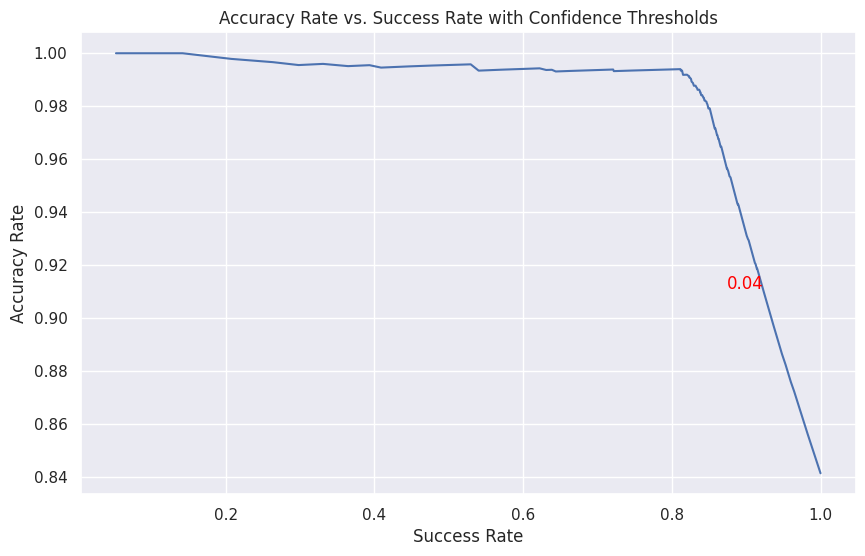

In [87]:
import seaborn as sns
sns.set()
def plot_success_vs_accuracy(success_rates, accuracy_rates, thresholds):
    plt.figure(figsize=(10, 6))
    
    plt.plot(success_rates, accuracy_rates, linestyle='-')
    plt.xlabel('Success Rate')
    plt.ylabel('Accuracy Rate')
    plt.title('Accuracy Rate vs. Success Rate with Confidence Thresholds')
    plt.grid(True)
    f_messure = f_mess(success_rates, accuracy_rates)

    # Annotate some key points with their corresponding confidence threshold
    index = np.argmax(f_messure)
    # #annotation_indices = np.linspace(0, len(thresholds) - 1, min(len(thresholds), 10), dtype=int)  # Up to 10 evenly spaced points
    # #for i in annotation_indices:
    print(thresholds[index])
    print(success_rates[index])
    print(accuracy_rates[index])
    plt.annotate(f'{thresholds[index]:.2f}', (success_rates[index], accuracy_rates[index]),
                    textcoords="offset points", xytext=(-10,-10),
                    ha='center', color='red')

    plt.show()


# Now, we'll use this function to plot the data and try to identify the optimal threshold
plot_success_vs_accuracy(success_rates, accuracy_rates, unique_confidences)


In [72]:
np.argmax(unique_confidences)

338

In [60]:
df_sorted

,Success,Result,confidence
389,False,False,0.0
554,False,False,0.0
107,False,False,0.0
400,False,False,0.0
577,False,False,0.0
...,...,...,...
1113,True,True,1.0
1115,True,True,1.0
1296,True,True,1.0
683,True,True,1.0


In [46]:
def accuracy_rate(data):
    rate = []
    for key, value in enumerate(data['confidence']):
        data_temp = deepcopy(data)
        #data_test = data.loc[data['confidence'] >= value, :]
        data_temp = data_temp.loc[data_temp['confidence'] >= value, :]
        accuracy_rate = len(data_temp.loc[data_temp['Result'] == True, :]) / len(data_temp)
        rate.append(sucess_rate)
    return rate

In [50]:
success_rate = sucess_rate(df)
accuracy_rate = accuracy_rate(df)

TypeError: 'list' object is not callable

In [48]:
success_rate[0]

0.8736141906873615

In [49]:
accuracy_rate[0]

<function __main__.sucess_rate(data)>

In [ ]:
# Initialize lists to store success rate and accuracy rate
success_rate = []
accuracy_rate = []

# Unique sorted list of confidence thresholds
unique_thresholds = np.unique(df_sorted['confidence'])

for threshold in unique_thresholds:
    # Consider a prediction successful if its confidence is >= threshold
    deemed_successful = df_sorted[df_sorted['confidence'] >= threshold]
    
    # Success rate: Proportion of predictions deemed successful
    success_rate.append(len(deemed_successful) / len(df_sorted))
    
    # Accuracy rate: Proportion of correct predictions among the deemed successful
    if len(deemed_successful) > 0:
        accuracy = np.mean(deemed_successful['Result'] == deemed_successful['Success'])
    else:
        accuracy = 0  # No predictions are deemed successful at this threshold
    
    accuracy_rate.append(accuracy)

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(unique_thresholds, success_rate, label='Success Rate', color='green')
plt.plot(unique_thresholds, accuracy_rate, label='Accuracy Rate', color='orange')
plt.xlabel('Confidence Threshold')
plt.ylabel('Rate')
plt.title('Success Rate and Accuracy Rate vs. Confidence Threshold')
plt.legend(loc='best')

plt.grid(True)
plt.show()


(array([ 258.,   52.,   18.,   12.,   19.,    9.,   30.,   35.,  103.,
        1719.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

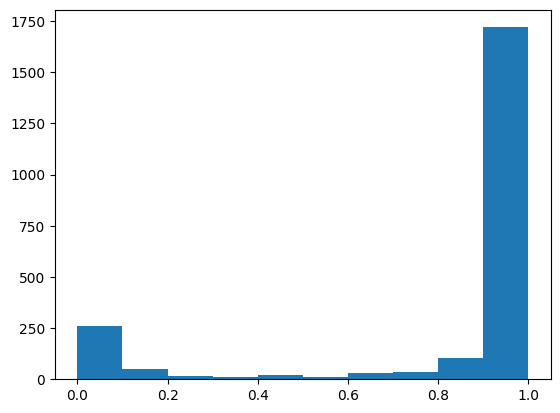

In [37]:
plt.hist(data_all['confidence'])

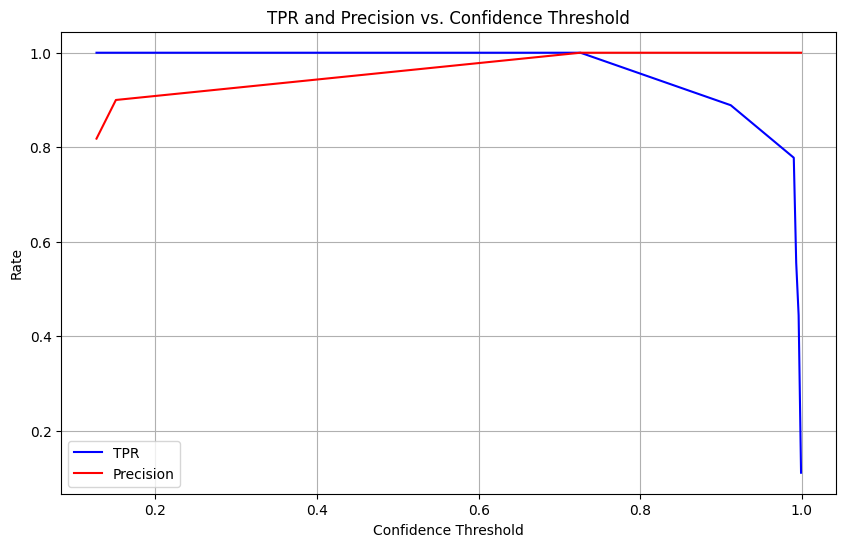

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sample data, replace this with the user's actual DataFrame
data = {
    'Success': [True, True, True, True, True, True, True, True, True, True, True],
    'Result': [False, True, True, True, False, True, True, True, True, True, True],
    'confidence': [0.127, 0.996, 0.999, 0.993, 0.151, 0.990, 0.726, 0.990, 0.912, 0.996, 0.996]
}

df = pd.DataFrame(data)

# Sort by confidence
df_sorted = df.sort_values(by='confidence')

# Calculate TPR and FPR at each threshold
thresholds = df_sorted['confidence']
TPR = []  # True Positive Rate
Precision = []  # Precision

for threshold in thresholds:
    TP = ((df_sorted['Result'] == True) & (df_sorted['confidence'] >= threshold)).sum()
    FP = ((df_sorted['Result'] == False) & (df_sorted['confidence'] >= threshold)).sum()
    FN = ((df_sorted['Result'] == True) & (df_sorted['confidence'] < threshold)).sum()
    
    tpr = TP / (TP + FN) if (TP + FN) != 0 else 0
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    
    TPR.append(tpr)
    Precision.append(precision)

# Plotting
plt.figure(figsize=(10, 6))

# For a more ROC-like curve, we might plot TPR vs. FPR. Here, we show TPR vs. Precision for illustration.
plt.plot(thresholds, TPR, label='TPR', color='blue')
plt.plot(thresholds, Precision, label='Precision', color='red')
plt.xlabel('Confidence Threshold')
plt.ylabel('Rate')
plt.title('TPR and Precision vs. Confidence Threshold')
plt.legend()

plt.grid(True)
plt.show()


In [86]:
data_pred = confidence_level(merge_data_path= '../../../Data/Validation_set/USPTO_diff/MCS/MCS_Impute.json.gz', 
                              mcs_data_path = '../../../Data/Validation_set/USPTO_diff/mcs_based_reactions.json.gz', 
                              scoring_function_path='./scoring_function.pkl', remove_undetected=True)

In [87]:
data_pred

,R-id,reactions,new_reaction,confidence,mcs_carbon_balanced
0,USPTO_diff_1151,Cc1nc(C(=O)N2CCC[C@@H](C)[C@H]2CNC(=O)OC(C)(C)...,Cc1nc(C(=O)N2CCC[C@@H](C)[C@H]2CNC(=O)OC(C)(C)...,0.997,True
1,USPTO_diff_1152,CC(C)(C)OC(=O)OC(=O)OC(C)(C)C.Cc1c([C@@H]2CN3C...,CC(C)(C)OC(=O)OC(=O)OC(C)(C)C.Cc1c([C@@H]2CN3C...,0.998,True
2,USPTO_diff_1153,O=C(OCc1ccccc1)c1cc(C(F)(F)F)cc(S(=O)(=O)Cc2cc...,O=C(OCc1ccccc1)c1cc(C(F)(F)F)cc(S(=O)(=O)Cc2cc...,0.995,True
3,USPTO_diff_1212,O=C(NC(Cc1ccc2[nH]ncc2c1)C(=O)N1CCN(C(=O)OCc2c...,O=C(NC(Cc1ccc2[nH]ncc2c1)C(=O)N1CCN(C(=O)OCc2c...,1.000,True
4,USPTO_diff_1213,O=CN(O)[C@H](CS(=O)(=O)CC1Cc2ccccc2C1)c1cccc(N...,O=CN(O)[C@H](CS(=O)(=O)CC1Cc2ccccc2C1)c1cccc(N...,0.999,True
...,...,...,...,...,...
473,USPTO_diff_1624,CCC(=O)c1ccc2c(c1)ncn2C.O=C(c1ccc(O)cc1)c1ccc(...,CCC(=O)c1ccc2c(c1)ncn2C.O=C(c1ccc(O)cc1)c1ccc(...,0.992,True
474,USPTO_diff_1625,Clc1ccc(C=C(Br)Br)c(Cl)c1>>C#Cc1ccc(Cl)cc1Cl,Clc1ccc(C=C(Br)Br)c(Cl)c1>>C#Cc1ccc(Cl)cc1Cl.B...,0.990,True
475,USPTO_diff_1626,COC(=O)c1ccc(F)cc1Br.O=[N+]([O-])c1ccc(F)cc1Br...,COC(=O)c1ccc(F)cc1Br.O=[N+]([O-])c1ccc(F)cc1Br...,0.994,True
476,USPTO_diff_1627,CCC(C(N)=O)N1CC(C=C(Br)Br)CC1=O>>C#CC1CC(=O)N(...,CCC(C(N)=O)N1CC(C=C(Br)Br)CC1=O>>C#CC1CC(=O)N(...,0.996,True


In [25]:
from SynRBL
import pickle
data_predict_name = 'USPTO_unbalance_class'
input_path = '../../../Pipeline'
source_path = '../../../Data'
process = AnalysisProcess(pipeline_path=input_path, data_path=source_path, data_predict_name=data_predict_name)
combined_data=process.process_predict_datasets()

X_pred = combined_data[['carbon_difference', 'fragment_count', 'total_carbons', 'total_bonds',
       'total_rings', 'num_boundary', 'ring_change_merge',
       'bond_change_merge']]


with open('scoring_function.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

confidence = loaded_model.predict_proba(X_pred)[:,1]
confidence

array([0.9732179 , 0.9999201 , 0.9985556 , 0.980602  , 0.9994814 ,
       0.99960846, 0.996942  , 0.9997547 , 0.9991072 , 0.996942  ,
       0.81488943, 0.9979438 , 0.9999739 , 0.99693775, 0.99997175,
       0.9999796 , 0.9997789 , 0.9983606 , 0.99569464, 0.9732179 ,
       0.9966897 , 0.99997175, 0.9997547 , 0.9994814 , 0.999524  ,
       0.9999201 , 0.99991834, 0.9972173 , 0.9998772 , 0.9998305 ,
       0.99995875, 0.99995875, 0.999982  , 0.99998736, 0.99918705,
       0.99995875, 0.999982  , 0.99932504, 0.99966395, 0.9998124 ,
       0.9996126 , 0.99996805, 0.37905622, 0.99995875, 0.99564797,
       0.9999026 , 0.96296096, 0.99918467, 0.99918467, 0.73850137,
       0.9989262 , 0.999982  , 0.9997749 , 0.99979204, 0.9997925 ,
       0.9976883 , 0.99984026, 0.999213  , 0.99833053, 0.9997882 ,
       0.99975127, 0.99975127, 0.9997447 , 0.99971336, 0.9997882 ,
       0.9806889 , 0.99975127, 0.9999243 , 0.9994773 , 0.9994773 ,
       0.99960405, 0.9990814 , 0.9998111 , 0.999571  , 0.99997

In [ ]:
data_raw = process.process_and_combine_datasets(remove_undetected=False).drop(['R-id', 'reactions', 'Bond Changes',
                                                                                'Index', 'mcs_carbon_balanced'], axis =1)



X, y = data_raw.drop('Result', axis=1), data_raw['Result']

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

steps = [('scaler', MinMaxScaler()), ('over', SMOTEENN(sampling_strategy='minority', random_state=42)), ('model', XGBClassifier(random_state=42))]
pipeline = Pipeline(steps=steps)

pipeline.fit(X_train, y_train)

In [ ]:
X_pred = combined_data[['carbon_difference', 'fragment_count', 'total_carbons', 'total_bonds',
       'total_rings', 'num_boundary', 'ring_change_merge',
       'bond_change_merge']]

In [19]:
combined_data.columns

Index(['R-id', 'reactions', 'carbon_difference', 'fragment_count',
       'total_carbons', 'total_bonds', 'total_rings', 'mcs_carbon_balanced',
       'num_boundary', 'ring_change_merge', 'bond_change_merge'],
      dtype='object')

In [8]:

with open('scoring_function.pkl', 'rb') as file:
    loaded_model = pickle.load(file)



In [10]:
X_test

,carbon_difference,fragment_count,total_carbons,total_bonds,total_rings,num_boundary,ring_change_merge,bond_change_merge
2064,5,3,27,7,0,1,0,0
1263,5,3,33,7,0,1,0,0
2128,4,3,24,7,1,1,0,0
599,18,6,66,32,2,2,0,0
464,1,8,37,3,0,1,0,0
...,...,...,...,...,...,...,...,...
1880,7,2,33,10,1,1,0,0
427,8,5,66,8,0,2,0,1
374,1,2,41,1,2,1,2,2
105,6,4,18,10,0,2,0,0


In [9]:
loaded_model.predict_proba(X_test)

array([[2.48730183e-04, 9.99751270e-01],
       [3.06487083e-04, 9.99693513e-01],
       [6.47306442e-05, 9.99935269e-01],
       [4.03838813e-01, 5.96161187e-01],
       [6.77817464e-02, 9.32218254e-01],
       [3.95953655e-04, 9.99604046e-01],
       [4.53586578e-02, 9.54641342e-01],
       [1.16554499e-02, 9.88344550e-01],
       [7.65562057e-04, 9.99234438e-01],
       [4.88758087e-05, 9.99951124e-01],
       [1.48475945e-01, 8.51524055e-01],
       [9.99754846e-01, 2.45162752e-04],
       [8.79271328e-01, 1.20728694e-01],
       [6.47306442e-05, 9.99935269e-01],
       [4.23701048e-01, 5.76298952e-01],
       [9.92853820e-01, 7.14617502e-03],
       [1.79111958e-04, 9.99820888e-01],
       [6.76167011e-03, 9.93238330e-01],
       [5.46404719e-02, 9.45359528e-01],
       [1.69992447e-04, 9.99830008e-01],
       [9.58025455e-04, 9.99041975e-01],
       [3.79323959e-04, 9.99620676e-01],
       [8.27478051e-01, 1.72521964e-01],
       [2.15003490e-02, 9.78499651e-01],
       [2.193987

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as Pipeline

data_raw = process.process_and_combine_datasets(remove_undetected=False).drop(['R-id', 'reactions', 'Bond Changes',
                                                                                'Index', 'mcs_carbon_balanced'], axis =1)


X, y = data_raw.drop('Result', axis=1), data_raw['Result']

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

steps = [('scaler', MinMaxScaler()), ('over', SMOTEENN(sampling_strategy='minority', random_state=42)), ('model', XGBClassifier(random_state=42))]
pipeline = Pipeline(steps=steps)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))